**In this analysis, game data from a total of 2559 regular season NFL games covering a span of ten years from 2010-2019 is considered, obtained from http://pro-football-reference.com. The aim of this regression analysis is to predict the total points in a given NFL contest based on game conditions and statistics from the participating teams averaged over the previous six games. Only contests taking place from the seventh week of the season to the last week of the regular season are considered for prediction, totalling 1734 games. A description of the features used in this analysis follows.**

**Descriptive Features** - Used solely to describe the contest in question
 * Home_Team - The name of the home team in the contest
 * Vis_Team - The name of the visiting team in the contest
 * H_Game - The number of points scored by the home team in the contest
 * V_Game - The number of points scored by the visiting team in the contest
 
**Analytical Features** - Features used in analysis
 * Tot_Pts - Total Points of the contest. **This is our target variable.**
 * Over/Under - The predicted total points of the contest from professional bookmakers.
 
*Averaged Features* - Statistics averaged over previous five contests. In the columns, prefix "H_" stands for Home Team and "V_" stands for Visiting Team
 * Pts - Points scored
 * Pts_Opp - Points scored by opponent
 * Off_Pass - Offensive passing yards
 * Pass_Metric - Average of offensive passing rank (32 - best, 1 - worst) and defensive passing rank of opponent (1 - best, 32 - worst)
 * Off_Rush - Offensive rushing yards
 * Rush_Metric - Average of offensive rushing rank and defensive rushing rank of opponent
 * Def_Pass - Passing yards given up on defensive
 * Def_Rush - Rushing yards given up on defensive
 * TD - Touchdowns scored
 * TD_on_Def - Touchdowns scored by defense
 * FG_Pct - Percentage of field goals made vs. field goals attempted
 * RZ_Pct - Percentage of red zone possessions resulting in a touchdown (red zone possession is possession reaching opponent's 20 yard line)
 * Def_RZ_Pct - Defensive percentage of red zone possessions giving up a touchdown
 * Poss - Time of possession
 * Plays - Total number of plays
 * TO_Gain - Number of turnovers gained by defense
 * TO_Lost - Number of turnovers lost by offense
 * Yds_Pen - Number of yards penalized
 * Sacks_Def - Sacks earned by defense
 * Tackles_Loss - Number of tackles for loss earned by defense
 * Kickret - Return yards from kickoff
 * Puntret - Return yards from punt
 
*Game Conditions* - Conditions of the contest in question
 * Temperature - Temperature of the contest at kickoff
 * surface - The surface on which the contest was played

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error

In [5]:
sns.set(font_scale=1.4)

In [4]:
teams = {'Atlanta Falcons':'atl','Buffalo Bills':'buf','Carolina Panthers':'car','Chicago Bears':'chi',
         'Cincinnati Bengals':'cin','Cleveland Browns':'cle','Indianapolis Colts':'clt',
         'Arizona Cardinals':'crd','Dallas Cowboys':'dal','Denver Broncos':'den','Detroit Lions':'det',
         'Green Bay Packers':'gnb','Houston Texans':'htx','Jacksonville Jaguars':'jax',
         'Kansas City Chiefs':'kan','Miami Dolphins':'mia','Minnesota Vikings':'min','New Orleans Saints':'nor',
         'New England Patriots':'nwe','New York Giants':'nyg','New York Jets':'nyj','Tennessee Titans':'oti',
         'Philadelphia Eagles':'phi','Pittsburgh Steelers':'pit','Oakland Raiders':'rai',
         'St. Louis Rams':'ram','Los Angeles Rams':'ram','Baltimore Ravens':'rav',
         'San Diego Chargers':'sdg','Los Angeles Chargers':'sdg','Seattle Seahawks':'sea',
         'San Francisco 49ers':'sfo','Tampa Bay Buccaneers':'tam','Washington Redskins':'was'}

In [554]:
num = 5 # number of games averaged over

In [454]:
import matplotlib as mpl
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

In [6]:
def combine_dummies(df, name, combine_cols):
    for col in combine_cols:
        ind=df[df[col]==1].index
        df.loc[ind,name] = col
        df.drop(col,axis=1,inplace=True)
    return df

In [7]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [8]:
def weekofgame(game):
    from datetime import timedelta, datetime as dt
    day_of_week={2:0,3:1,4:2,5:3,6:4,0:5,1:6} #day of week starts on Wednesday
    date = dt.strptime(game[0:8],'%Y%m%d')
# .weekday() returns the day of the week for datetime.datetime   
    beg_week = date - timedelta(days=day_of_week[date.weekday()])
    fmt = lambda x: str(x) if x >= 10 else '0'+str(x)
    return(fmt(beg_week.month)+fmt(beg_week.day))

In [9]:
def get_year(code):
    if (code[4:6] == '01'):
        year = str(int(code[0:4])-1)
    else:
        year = str(int(code[0:4]))
    return year

In [10]:
def get_mapping(group,n):
    d={}
    keys = sorted(group['Week_Beg'].unique())
    values = [i for i in range((n+1),(n+1)+len(keys))]
    for key,value in zip(keys,values):
        d[key] = value
    return d

In [11]:
def bootstrap(data,n,func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        rows = np.random.permutation(data.index)
        ind = data[rows[0:n]].index
        arr[i] = func(data[ind])
    return arr

In [12]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [13]:
def diff_of_means(data1, data2):
    """Difference in means of two arrays."""

    # The difference of means of data1, data2: diff
    diff = np.mean(data1) - np.mean(data2)

    return diff

In [14]:
def permuted(data1, data2, func):
    n_replicates = 10000
    arr = np.empty(n_replicates)
    for i in range(n_replicates):
        perm1, perm2 = permutation_sample(data1,data2)
        arr[i] = func(perm1, perm2)
    return arr

In [361]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [15]:
def ou_accuracy(actu,pred):
    global dfall
    ou = dfall.loc[actu.index,'Over/Under']
    if not((len(actu) == len(pred)) & (len(pred) == len(ou))):
        if (len(actu) != len(pred)):
            raise ValueError(f'Length mismatch among arguments: actual != predicted ({len(actu)} != {len(pred)})')
        else:
            raise ValueError(f'Length mismatch among arguments: predicted != Over/Under ({len(pred)} != {len(ou)})')
    else:
        corr = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
        tot = (actu<ou).sum() + (actu>ou).sum()
        return corr/tot

In [16]:
def regress(reg,Xtrain,Xtest,ytrain,ytest,cv=5,print_metrics=True,print_coef=True,return_metrics=False):
    robust = RobustScaler()
    sca_train = robust.fit_transform(Xtrain)
    sca_test = robust.transform(Xtest)
    val = cross_validate(reg, sca_train, ytrain, cv=cv, return_estimator=True,
                                scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
                                        'acc':make_scorer(ou_accuracy,greater_is_better=True)})
    acc = (np.mean(val['test_acc']),np.std(val['test_acc']))
    mae = (np.mean(-val['test_mae']),np.std(-val['test_mae']))
    best_estimator = val['estimator'][val['test_mae'].argmax()]

    ypred=best_estimator.predict(sca_test)
    mae_test=mean_absolute_error(ytest,ypred)
    acc_test = ou_accuracy(ytest,ypred)
    sorted_coef = get_coef(best_estimator.coef_,Xtrain.columns)
    if print_metrics:
        print(f'MAE_train = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
        print(f'MAE_test = {mae_test:.3f}, Accuracy_test = {acc_test:.3f}')
    if print_coef:
        print(sorted_coef)
    if return_metrics:
        return mae_test,acc_test
    else:
        return

In [17]:
def get_coef(coef_,cols):
    coef = pd.DataFrame(coef_, cols, columns=['LR Coefficient'])
    ind=np.flip(np.argsort(abs(coef_)))
    return coef.iloc[ind]

In [18]:
path = 'data/df_complete.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)

In [19]:
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf']

In [555]:
path = 'data/df_working'+str(num)+'.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)

In [21]:
dfgame.drop(turf,axis=1,inplace=True)

In [556]:
from sklearn.model_selection import train_test_split

train_ratio = 0.85
#validation_ratio = 0.15
test_ratio = 0.15

X_show = dfgame.copy(deep=False)
y = np.ravel(dfgame['Tot_Pts'])
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
# 70% split for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 77)
# # 15%, 15% split for validation, test data
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
#                                                 test_size = test_ratio/(test_ratio + validation_ratio), random_state = 77)
X_show = X_show.loc[X_train.index]

In [305]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

**The barplot demonstrates the quantized nature of football scoring. The significant advantage of the home team is indicated in the scoring as well as in the pie chart.** 

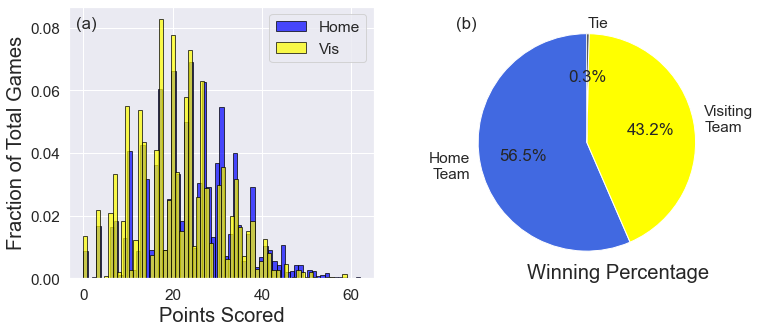

In [378]:
scores = dfall[['H_Game','V_Game']].rename({'H_Game':'Home','V_Game':'Vis'},axis=1)
fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
_ = plt.xlabel('Points Scored',fontsize='large')
_ = plt.ylabel('Fraction of Total Games',fontsize='large')
_ = plt.hist(scores['Home'],bins=63,density=True,color='blue',ec='black',alpha=0.7,
         label='Home')
_ = plt.hist(scores['Vis'],bins=63,density=True,color='yellow',ec='black',alpha=0.7,
         label='Vis')
_ = plt.legend(loc='upper right')
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes)
ax2 = plt.subplot(1,2,2)
win = np.array([(scores['Home'] > scores['Vis']).sum(),(scores['Home'] < scores['Vis']).sum(),
                 (scores['Home'] == scores['Vis']).sum()])
labels = 'Home'+'\n'+'Team', 'Visiting'+'\n'+'Team', 'Tie'
colors = ('royalblue','yellow','black')
_ = plt.pie(win/sum(win),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,startangle=90)
_ = plt.text(0.28,0.00,'Winning Percentage',transform=ax2.transAxes,fontsize='large')
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes)
fig1.show()
fig1.savefig('plots/fig1.png',bbox_inches='tight')

**We can see the range of total score is much larger than that of the Over/Under (3X) with a positive correlation of 0.28.**

In [356]:
from scipy import stats   

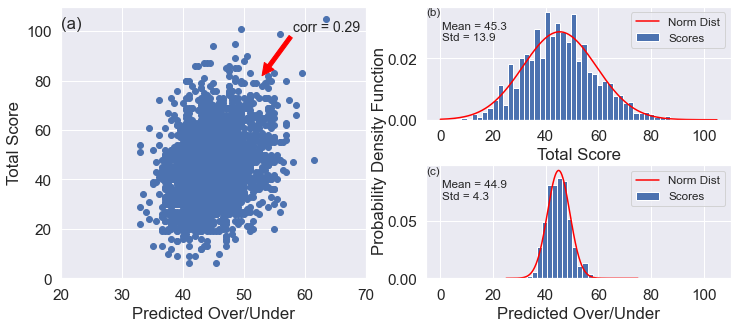

In [392]:
import matplotlib.gridspec as gridspec
from scipy import stats   

fig2 = plt.figure(figsize=(12,5))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

inner_l = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax = plt.Subplot(fig2, inner_l[0])
ax.scatter(dfall['Over/Under'],dfall['Tot_Pts'])
ax.set_xlim((20,70))
ax.set_ylim((0,110))
ax.set_xlabel('Predicted Over/Under')
ax.set_ylabel('Total Score')
ax.annotate('corr = 0.29',xy=(53,82),xytext=(58,100),arrowprops={'color':'red'},fontsize='small')
ax.text(0.00,0.92,'(a)',transform=ax.transAxes)

fig2.add_subplot(ax)

inner_r = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[1],hspace=0.4)
j=0
mu = np.mean(dfall['Tot_Pts'])
sig = np.std(dfall['Tot_Pts'])
ax0 = plt.Subplot(fig2, inner_r[j])
ax0.set_xlabel('Total Score')
ax0.hist(dfall['Tot_Pts'],bins=50,density=True,label='Scores')
xx = np.linspace(0,105,1000)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
ax0.plot(xx,yy,color='red',label='Norm Dist')
ax0.legend(loc='upper right',fontsize='x-small')
ax0.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax0.transAxes,fontsize='x-small')
ax0.text(0.00,0.92,'(b)',transform=ax0.transAxes,fontsize='x-small')
fig2.add_subplot(ax0)
j=1
mu = np.mean(dfall['Over/Under'])
sig = np.std(dfall['Over/Under'])
ax1 = plt.Subplot(fig2, inner_r[j], sharex=ax0)
ax1.hist(dfall['Over/Under'],bins=16,density=True,label='Scores')
xx = np.linspace(25,75,500)
yy = stats.norm.pdf(xx,loc=np.mean(dfall['Over/Under']),scale=np.std(dfall['Over/Under']))
ax1.plot(xx,yy,color='red',label='Norm Dist')
ax1.legend(loc='upper right',fontsize='x-small')
ax1.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax1.transAxes,fontsize='x-small')
ax1.text(0.00,0.92,'(c)',transform=ax1.transAxes,fontsize='x-small')
fig2.add_subplot(ax1)
fig2.text(0.485,0.20,'Probability Density Function',rotation='vertical')
ax1.set_xlabel('Predicted Over/Under')
fig2.show()
fig2.savefig('plots/fig2.png',bbox_inches='tight')

In [395]:
error = dfall['Tot_Pts'] - dfall['Over/Under']

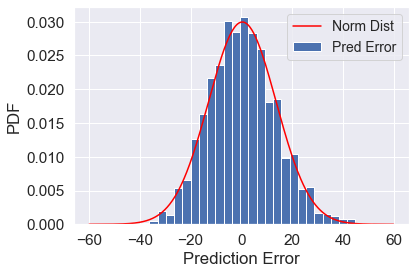

In [402]:
mu = np.mean(error)
sig = np.std(error)
xx = np.linspace(-60,60,500)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
fig3 = plt.figure()
_ = fig3.add_subplot(1,1,1)
_ = plt.xlabel('Prediction Error')
_ = plt.ylabel('PDF')
_ = plt.hist(error,bins=28,density=True,label='Pred Error')
_ = plt.plot(xx,yy,color='red',label='Norm Dist')
_ = plt.legend(loc='upper right',fontsize='small')
fig3.show()
fig3.savefig('plots/fig3.png',bbox_inches='tight')

**This boxplot shows the symmetry of the error data around 0 and the larger number of positive outliers in the Over/Under prediction error.** 

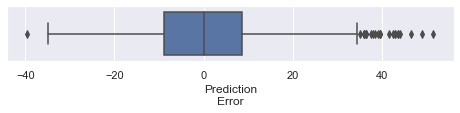

In [357]:
fig4 = plt.figure(figsize=(8,1))
error = pd.Series(error,name='Prediction'+'\n'+'Error')
_ = sns.boxplot(error, orient='h')
fig4.show()
fig4.savefig('plots/fig4.png',bbox_inches='tight')

**There is remarkable symmetry in the Over/Under prediction error, as well as in the Over vs. Under wins. This symmetry is also revealed in the median error, although a greater number of outliers to the upside is reflected in the average error.** 

The median and average errors for the Over are 9.0 and 11.1 points
The median and average errors for the Under are -9.0 and -10.3 points


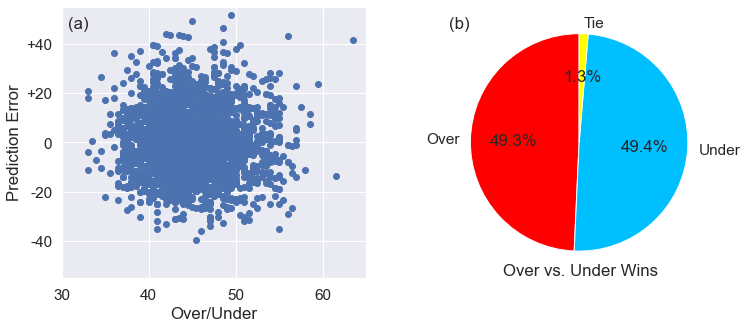

In [403]:
import matplotlib.ticker as tick
fig5, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5)) 
error = dfall['Tot_Pts'] - dfall['Over/Under']
ax1.set_ylim(-55,55)
ax1.set_xlim(30,65)
ax1.set_xlabel('Over/Under')
ax1.set_ylabel('Prediction Error')
ax1.scatter(dfall['Over/Under'],error)
def y_tk_fmt(x,y):
    if x > 0:
        return '{:+d}'.format(int(x))
    else:
        return '{:d}'.format(int(x))
ax1.yaxis.set_major_formatter(tick.FuncFormatter(y_tk_fmt))
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes,fontsize='medium')
o_u = np.array([(dfall['Tot_Pts'] > dfall['Over/Under']).sum(),
                (dfall['Tot_Pts'] < dfall['Over/Under']).sum(),
                 (dfall['Tot_Pts'] == dfall['Over/Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')
ax2.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,
        startangle=90)
ax2.text(0.22,0.01,'Over vs. Under Wins',transform=ax2.transAxes)
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes,fontsize='medium')
fig5.show()
fig5.savefig('plots/fig5.png',bbox_inches='tight')
import statistics
pos = error[error > 0]
neg = error[error < 0]
print('The median and average errors for the Over are {0:.1f} and {1:.1f} points'
      .format(pos.median(),pos.mean()))
print('The median and average errors for the Under are {0:.1f} and {1:.1f} points'
      .format(neg.median(),neg.mean()))

In [404]:
Q3=error.quantile(0.75)
Q1=error.quantile(0.25)
IQR = Q3-Q1
outliers = dfall.loc[error > 1.5*IQR,:]
outlier_year = pd.Series([int(x[0:4]) for x in outliers.index])
year_counts = outlier_year.value_counts().sort_index()

In [458]:
# Calculate percentage of 'Overs' by year 
#year = pd.DataFrame([int(x[0:4]) for x in dfall.index],columns = ['Year'],index=dfall.index)
year = pd.DataFrame(index=dfall.index,columns=['Year'])
for ind in dfall.index: 
    year.loc[ind,'Year'] = int(get_year(ind))
    year.loc[ind,'Team'] = ind[-3:]
year['Over'] = dfall['Tot_Pts'] > dfall['Over/Under']
over_count_year = year['Over'].groupby(year.Year).mean()
year['Week'] = dfall['Week']
over_count_week = year['Over'].groupby(year.Week).mean()

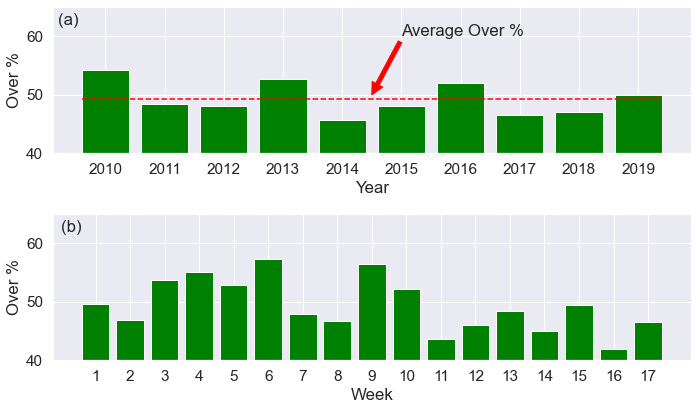

In [690]:
fig6 = plt.figure(figsize=(10,6))
_ = fig6.add_subplot(2,1,1)
_ = plt.xlabel('Year')
_ = plt.ylabel('Over %')
_ = plt.bar(year_counts.index,over_count_year.values*100,color='green',
       tick_label=[str(i) for i in range(2010,2020)])
_ = plt.ylim(40,65)
_ = plt.hlines(49.3,2009.6,2019.4,linestyle='dashed',colors='red')
_ = plt.annotate('Average Over %',xy=(2014.5,50),xytext=(2015,60),arrowprops={'color':'red'})
_ = plt.text(2009.2,62,'(a)',fontsize='medium')
_ = fig6.add_subplot(2,1,2)
_ = plt.xlabel('Week')
_ = plt.ylabel('Over %')
_ = plt.bar(range(1,18),over_count_week.values*100,color='green',
       tick_label=[str(i) for i in range(1,18)])
_ = plt.ylim(40,65)
_ = plt.text(0.01,62,'(b)',fontsize='medium')
fig6.tight_layout()  
fig6.show()
fig6.savefig('plots/fig6.png')

In [606]:
tp=dfall[['Tot_Pts','Over/Under','Week']]

In [607]:
tp['Pass_Yds'] = dfall['H_Off_Pass'] + dfall['V_Off_Pass']

In [608]:
tp['Rush_Yds'] = dfall['H_Off_Rush'] + dfall['V_Off_Rush']

In [618]:
tpmelt=pd.melt(tp,id_vars=['Week'],value_vars=['Tot_Pts','Over/Under','Pass_Yds','Rush_Yds'],
              var_name='Feature')

In [633]:
tppivot=pd.pivot_table(tp,index=['Week'],values=['Tot_Pts','Over/Under','Pass_Yds','Rush_Yds'],aggfunc='mean')

In [631]:
tppivot.loc[1:16,['Pass_Yds','Rush_Yds']]=tppivot.loc[2:17,['Pass_Yds','Rush_Yds']]

In [636]:
tppivot.loc[1,'Pass_Yds'] = tppivot.loc[2,'Pass_Yds']

In [711]:
# Get Passing and Rushing Yards for Final Week of Season
py = 0
ry = 0
num = 0
for year in range(2010,2020):
    path=f'data/df_step2_{str(year)}.data'
    with open(path,'rb') as f:
        raw=pickle.load(f)
    codes = [raw.loc[team].index[-1] for team in raw.index.levels[0]]
    codes = set(codes)
    for code in codes:
        team = code[-3:]
        py += raw.loc[(team,code),'Yds_Off_Pass'] + raw.loc[(team,code),'Yds_Def_Pass']
        ry += raw.loc[(team,code),'Yds_Off_Rush'] + raw.loc[(team,code),'Yds_Def_Rush']
    num += len(codes)
py = py/num
ry = ry/num
tppivot.loc[17,'Pass_Yds'] = py
tppivot.loc[17,'Rush_Yds'] = ry

In [712]:
tppivot

,Over/Under,Pass_Yds,Rush_Yds,Tot_Pts
Week,,,,
1,44.556604,503.862500,205.256250,45.125786
2,44.746875,511.887500,215.400000,43.981250
3,44.734375,514.181208,216.456376,46.012500
4,45.003356,528.154930,227.971831,46.449664
5,45.260563,512.608392,228.391608,45.985915
6,45.440559,509.704225,226.302817,46.426573
7,45.066901,492.452555,228.985401,45.070423
8,45.273723,492.082707,222.293233,45.613139
9,45.180451,522.364286,229.285714,47.533835


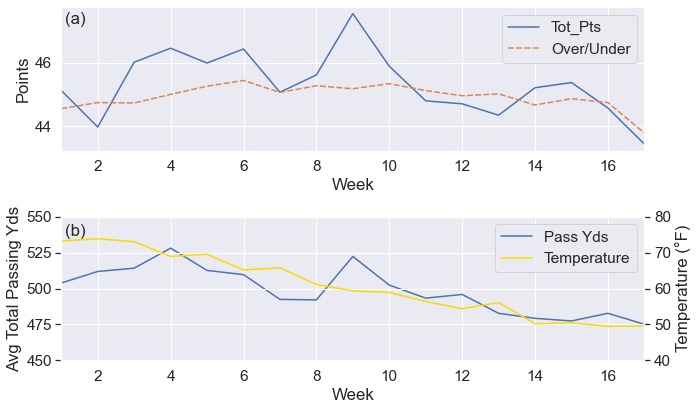

In [778]:
fig8 = plt.figure(figsize=(10,6))
_ = fig8.add_subplot(2,1,1)
_ = sns.lineplot(data=tppivot[['Tot_Pts','Over/Under']])
_ = plt.xlim(1,17)
_ = plt.ylabel('Points')
_ = plt.text(1.1,47.2,'(a)',fontsize='medium')
ax1 = fig8.add_subplot(2,1,2)
ax1.plot(tppivot.index,tppivot['Pass_Yds'],label='Pass Yds')
ax1.set_xlabel('Week')
ax1.set_ylabel('Avg Total Passing Yds')
ax1.text(1.1,537,'(b)',fontsize='medium')
ax1.set_ylim(450,550)
ax1.set_xlim(1,17)
ax2 = ax1.twinx()
ax2.plot(range(1,18),temp_by_week,color='gold',label='Temperature')
ax2.set_ylabel('Temperature (°F)')
ax2.set_ylim(40,80)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
fig8.tight_layout()  
fig8.show()
fig8.savefig('plots/fig8.png')

In [544]:
path=f'data/df_raw.pkl'
with open(path,'rb') as f:
    dfraw=pickle.load(f)
codes = dfraw.index.levels[1]
codes = set(codes)
pyds = pd.DataFrame(index=codes,columns=['Home_Pass_Yds','Vis_Pass_Yds','Tot_Pass_Yds','Wind','Temperature','Humidity'])
for code in pyds.index:
    home = code[-3:]
    pyds.loc[code,'Home_Pass_Yds'] = dfraw.loc[(home,code),'Yds_Off_Pass']
    pyds.loc[code,'Vis_Pass_Yds'] = dfraw.loc[(teams[dfraw.loc[(home,code),'Opponent']],code),'Yds_Off_Pass']
    pyds.loc[code,'Tot_Pass_Yds'] = pyds.loc[code,'Home_Pass_Yds'] + pyds.loc[code,'Vis_Pass_Yds']
    pyds.loc[code,'Wind'] = dfall.loc[code,'Wind']
    pyds.loc[code,'Temperature'] = dfall.loc[code,'Temperature']
    pyds.loc[code,'Humidity'] = dfall.loc[code,'Humidity']

In [545]:
for col in pyds.columns: pyds[col]=pd.to_numeric(pyds[col])

In [546]:
pyds['Week'] = dfall['Week']

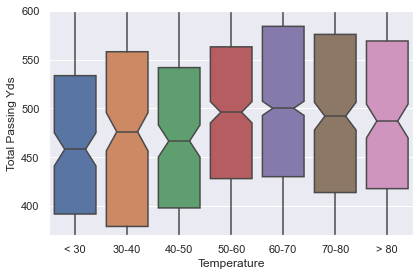

In [550]:
fig9 = plt.figure(figsize=(6,4))
_ = fig.add_subplot(1,1,1)
bins = [-10,30,40,50,60,70,80,100]
pyds['Bin'] = pd.cut(pyds.Temperature,bins)
sns.boxplot(x='Bin',y='Tot_Pass_Yds',data=pyds,
            notch=True).set(xlabel='Temperature',ylim=(370,600),
                            ylabel='Total Passing Yds',xticklabels=['< 30','30-40','40-50','50-60','60-70','70-80','> 80'])
plt.tight_layout()
plt.show()
fig9.savefig('plots/fig9.png')

In [742]:
np.corrcoef(pyds['Tot_Pass_Yds'],pyds.Wind)

array([[ 1.        , -0.13250385],
       [-0.13250385,  1.        ]])

In [743]:
np.corrcoef(pyds['Tot_Pass_Yds'],pyds.Temperature)

array([[1.        , 0.11862414],
       [0.11862414, 1.        ]])

In [744]:
np.corrcoef(pyds['Tot_Pass_Yds'],pyds.Humidity)

array([[ 1.        , -0.08306169],
       [-0.08306169,  1.        ]])

In [746]:
wind_by_week = pyds['Wind'].groupby(pyds.Week).mean()

In [747]:
temp_by_week = pyds['Temperature'].groupby(pyds.Week).mean()

In [748]:
hum_by_week = pyds['Humidity'].groupby(pyds.Week).mean()

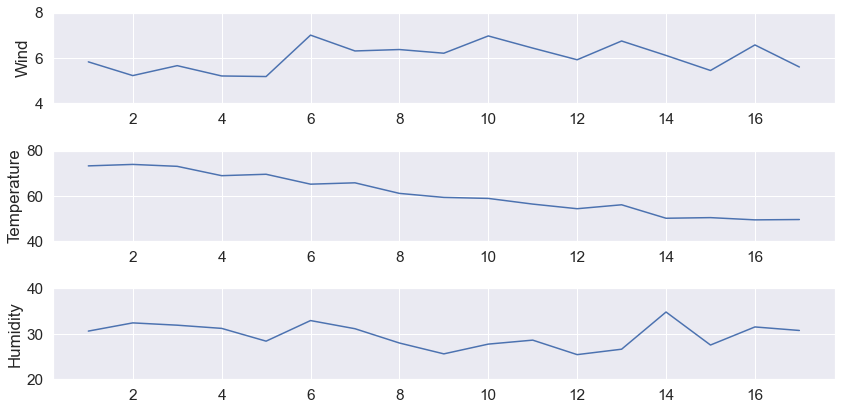

In [750]:
fig = plt.figure(figsize=(12,6))
_ = fig.add_subplot(3,1,1)
_ = plt.plot(range(1,18),wind_by_week)
_ = plt.ylim(4,8)
_ = plt.ylabel('Wind')
# _ = plt.text(1.1,47.2,'(a)',fontsize='medium')
_ = fig.add_subplot(3,1,2)
_ = plt.plot(range(1,18),temp_by_week)
# _ = plt.xlabel('Week')
_ = plt.ylabel('Temperature')
_ = plt.ylim(40,80)
# _ = plt.text(1.1,537,'(b)',fontsize='medium')
_ = fig.add_subplot(3,1,3)
_ = plt.plot(range(1,18),hum_by_week)
_ = plt.ylabel('Humidity')
_ = plt.ylim(20,40)
fig.tight_layout()  
fig.show()

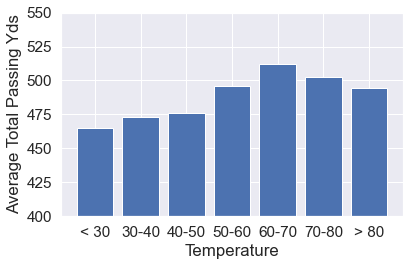

In [768]:
fig = plt.figure(figsize=(6,4))
_ = fig.add_subplot(1,1,1)
bins = [-10,30,40,50,60,70,80,100]
grouped = pyds.groupby(pd.cut(pyds.Temperature,bins))
ind = np.arange(len(grouped['Tot_Pass_Yds'].mean()))
_ = plt.bar(ind,grouped['Tot_Pass_Yds'].mean().values)
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(400,550)
_ = plt.ylabel('Average Total Passing Yds')
_ = plt.xlabel('Temperature')
plt.tight_layout()
plt.show()

In [875]:
len(domed)/len(dfall)

0.2637749120750293

In [590]:
dfwk['Year']=get_year()

,Tot_Pts,H_Off_Pass,V_Off_Pass,H_Def_Pass,V_Def_Pass,H_Off_Rush,V_Off_Rush,H_Def_Rush,V_Def_Rush,Week,Tot_Off,Tot_Def,Weeks,Over/Under,Over
Code,,,,,,,,,,,,,,,
201009190atl,48.0,252.0,297.0,236.0,253.0,58.0,112.0,143.0,85.0,2,719.0,717.0,1-10,43.5,1
201009260nor,51.0,254.0,225.0,275.0,164.0,50.0,221.0,142.0,118.0,3,750.0,699.0,1-10,49.5,1
201010030atl,30.0,228.0,232.0,365.0,250.0,202.0,43.0,43.0,207.0,4,705.0,865.0,1-10,42.5,0
201010100cle,30.0,184.0,273.0,371.0,188.0,116.0,98.0,67.0,81.0,5,671.0,707.0,1-10,41.5,0
201010170phi,48.0,253.0,187.0,309.0,246.0,125.0,165.0,74.0,48.0,6,730.0,677.0,1-10,43.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201909090rai,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1-10,42.5,0
201909050chi,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1-10,47.0,0
201909080min,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,1-10,47.0,0


In [470]:
over_count_year.values,(np.mean(over_count_year.values),np.std(over_count_year.values))

(array([0.54296875, 0.484375  , 0.48046875, 0.52734375, 0.45703125,
        0.48046875, 0.51953125, 0.46484375, 0.47058824, 0.5       ]),
 (0.4927619485294118, 0.027213925384153684))

In [562]:
data = pd.DataFrame(over_count_week.values,columns=['Over%'])
data.loc[0:9,'Week'] = '1-10'
data.loc[10:16,'Week'] = '11-17'

In [652]:
data.loc[10:].median()

Over%    0.461039
dtype: float64

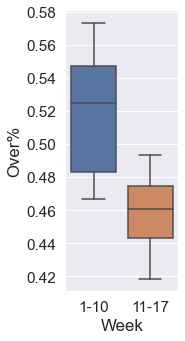

In [676]:
fig7 = plt.figure(figsize=(3,5))
_ = fig.add_subplot(1,1,1)
_ = sns.boxplot(x='Week',y='Over%',data=data,orient='v')
plt.tight_layout()
plt.show()
fig7.savefig('plots/fig7.png')

In [471]:
np.mean(over_count_week.values[0:10]),np.mean(over_count_week.values[10:])

(0.5186401373865642, 0.4585491734200022)

In [472]:
np.std(over_count_week.values[0:10]),np.std(over_count_week.values[10:])

(0.03702116757657415, 0.024178569311271096)

In [476]:
t_result,p_result=stats.ttest_ind(early['Tot_Pts']>early['Over/Under'],late['Tot_Pts']>late['Over/Under'],
                                  equal_var=False)
print(f't = {t_result}, p = {p_result}')

t = 2.9695783059319183, p = 0.003012172382674586


In [686]:
import pingouin as pg
res = pg.ttest(early['Tot_Pts']>early['Over/Under'],late['Tot_Pts']>late['Over/Under'],
               correction=True,tail='two-sided')
print(res)

               T          dof       tail     p-val        CI95%   cohen-d  \
T-test  2.969578  2357.912853  two-sided  0.003012  [0.02, 0.1]  0.118614   

         BF10     power  
T-test  3.574  0.843122  


In [673]:
res = pg.ttest(early['Tot_Pts']>early['Over/Under'],late['Tot_Pts']>late['Over/Under'],
               correction=True,tail='greater')
print(res)

               T          dof     tail     p-val        CI95%   cohen-d  \
T-test  2.969578  2357.912853  greater  0.001506  [0.03, inf]  0.118614   

         BF10     power  
T-test  7.149  0.907051  


In [503]:
early_over_means=bootstrap(early['Tot_Pts']>early['Over/Under'],160,np.mean)
late_over_means=bootstrap(late['Tot_Pts']>late['Over/Under'],160,np.mean)

In [679]:
(np.percentile(early_over_means,2.5),np.percentile(early_over_means,97.5))

(0.44375, 0.59375)

In [681]:
np.percentile(early_over_means,22.36)

0.4875

In [680]:
(np.percentile(late_over_means,2.5),np.percentile(late_over_means,97.5))

(0.3875, 0.53125)

In [683]:
np.percentile(late_over_means,77.64)

0.4875

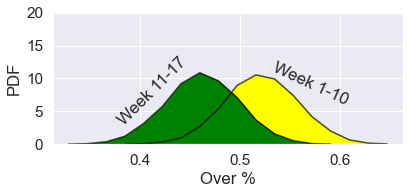

In [661]:
fig = plt.figure(figsize=(6,3))
_ = fig.add_subplot(1,1,1)
bins=15
n,x = np.histogram(early_over_means,bins=bins,density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n,color='black',alpha=0.7) ## using bin_centers rather than edges
plt.fill_between(bin_centers,n,color='yellow')
bins=15
n,x = np.histogram(late_over_means,bins=bins,density=True)
#_ = plt.hist(late_over_means,bins=15,density=True)
bin_centers = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers,n,color='black',alpha=0.7) ## using bin_centers rather than edges
plt.fill_between(bin_centers,n,color='green')
_ = plt.ylim(0,20)
_ = plt.text(0.375,3,'Week 11-17',rotation=45)
_ = plt.text(0.53,6,'Week 1-10',rotation=335)
_ = plt.xlabel('Over %')
_ = plt.ylabel('PDF')
fig.tight_layout()
plt.show()

In [689]:
over_means=bootstrap(dfall['Tot_Pts']>dfall['Over/Under'],195,np.mean)

mu = np.mean(over_means)
sd = np.std(over_means)
pct2_5 = np.percentile(over_means,2.5)
pct97_5 = np.percentile(over_means,97.5)
x = np.arange(pct2_5,pct97_5,0.001)
ymax = 14.0
y1 = ymax
y2 = 0.0
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
_ = plt.hist(over_means,bins=49,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
ax.text(0.05,0.2,'95% Conf. Int. =\n [{0:.3f},{1:.3f}]'.format(pct2_5,pct97_5),
                                                               transform=ax.transAxes,fontsize='small')
ax.fill_between(x, y1, y2,color='lightgreen',alpha=0.5)
_ = plt.vlines(pct2_5,0,ymax,color='red',alpha=0.8)
_ = plt.vlines(pct97_5,0,ymax,color='red',alpha=0.8)
_ = plt.scatter(over_count.values[0],0.4,marker='.',color='red',s=200,zorder=2)
ax. text(0.58,1.2,'2010 Over%',fontsize='small')
fig.tight_layout()
plt.show()

In [655]:
over_count.values[0]

0.5794871794871795

In [687]:
import scipy.stats
p = 1.0-stats.percentileofscore(over_means,over_count.values[0])/100
print(f'p-value is {p:.4f}')

p-value is 0.0055


In [25]:
X_train.shape

(1333, 48)

**The following correlation matrix reveals that there seems to be a much greater correlation between the scoring history of the teams and the predicted over/under (0.45,0.46) than between the scoring history and the actual total score of the predicted game (0.14,0.13). In addition, there is little to no correlation between the opposing teams' scores of the last five games and the total score of the game in question (0.00,0.05). Also revealed is that there is significant correlation between red zone percentage and scoring history, as expected, but little correlation with scoring history and field goal percentage. The importance of red zone percentage is reflected in the over/under prediction, but less so in the actual total score.**

In [558]:
len(X_show)

1473

In [560]:
len(df)

1473

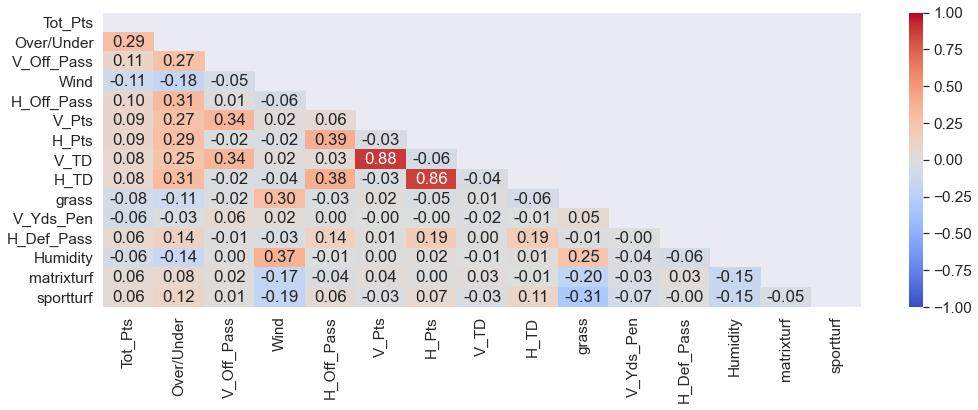

In [559]:
fig14 = plt.figure(figsize=(15,6))
ax = fig14.add_subplot(1,1,1)

df = dfall.loc[X_show.index]
#df = X_show
cols = df.columns.drop(['Home_Team','Vis_Team','H_Game','V_Game'])
corrs = [np.abs(df['Tot_Pts'].corr(df[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = df[newcols[0:15]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
fig14.tight_layout()
fig14.show()
fig14.savefig('plots/fig14.png')

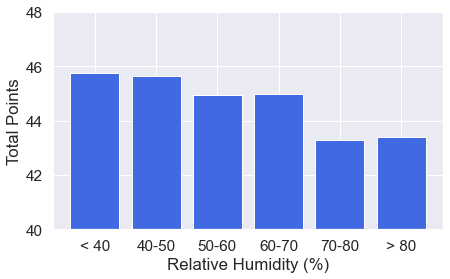

In [820]:
fig77 = plt.figure(figsize=(7,4))
bins = [0,40,50,60,70,80,100]
grouped = dfall.groupby(pd.cut(dfall.Humidity,bins))
# counts = grouped['Tot_Pts'].count().values
# alp = counts/max(counts)
# colors = [(0,0,0.5,alp[a]) for a in range(len(alp))]
ind = np.arange(len(grouped['Humidity'].mean()))
_ = plt.bar(ind,grouped['Tot_Pts'].mean().values,color='royalblue')
_ = plt.xticks(ind,labels=('< 40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(40,48)
_ = plt.xlabel('Relative Humidity (%)')
_ = plt.ylabel('Total Points')
fig.tight_layout()
plt.show()
fig77.savefig('plots/fig77.png')

In [817]:
grouped['Tot_Pts'].count()

Humidity
(0, 40]      188
(40, 50]     171
(50, 60]     234
(60, 70]     196
(70, 80]     152
(80, 100]    153
Name: Tot_Pts, dtype: int64

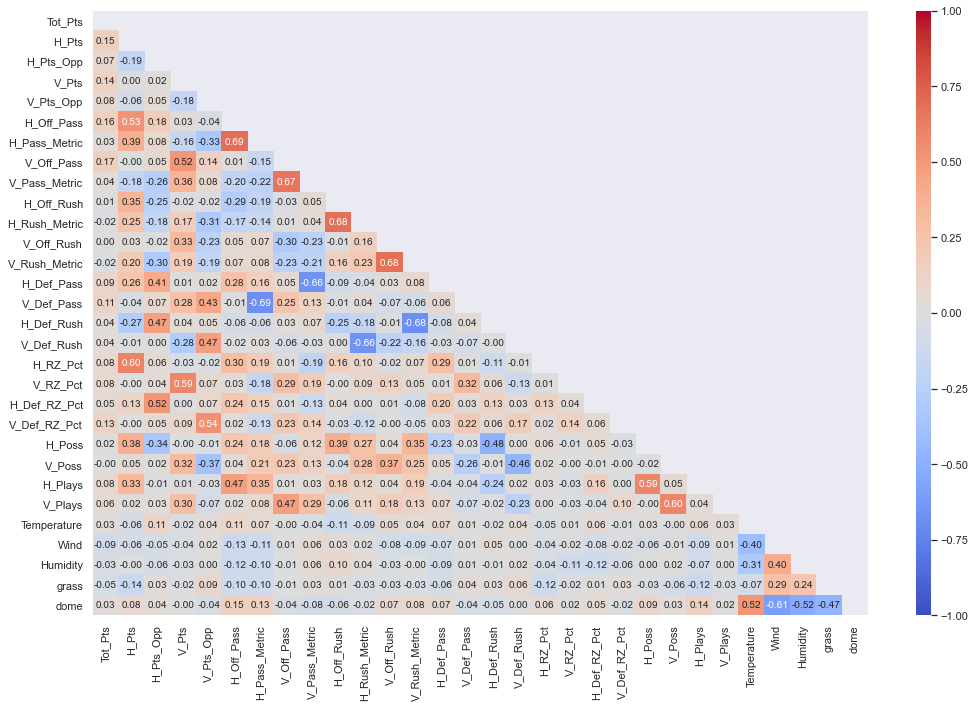

In [549]:
fig15 = plt.figure(figsize=(15,10))
ax = fig15.add_subplot(1,1,1)

dropped = ['Home_Team','Vis_Team','H_Game','V_Game','Over/Under']
                 
cols=X_show.columns.drop(dropped)
#corrs = [np.abs(X_show['Tot_Pts'].corr(X_show[col])) for col in cols]
#sortcorr = sorted(corrs,reverse=True)
#mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
#newcols = [cols[mapa[ind]] for ind in range(len(cols))] 

Stats=X_show[cols]
coeffs = Stats.corr()
moretodrop = []
for col in cols:
    if (col != 'Tot_Pts'):
        max_coef = coeffs.loc[col,np.abs(coeffs.loc[col]).rank(ascending=False) == 2].values[0] # neglect self-correlation
        if np.abs(max_coef) < 0.4: moretodrop.append(col)
coeffs = coeffs.drop(moretodrop).drop(moretodrop,axis=1)
mask = np.triu(coeffs)
#sns.set(font_scale=0.8)
sns.set(font_scale=1.0)
sns.heatmap(coeffs,vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',cbar_kws={'aspect':40},fmt='.2f',annot_kws={"size": 10})
fig15.tight_layout()
fig15.show()
fig15.savefig('plots/fig15.png')

In [34]:
LR = linear_model.LinearRegression()

In [35]:
standard = StandardScaler()
robust = RobustScaler()

In [36]:
from sklearn.metrics import mean_absolute_error

In [115]:
def rnd_valid(reg, X, y, cv=5):
    acc = np.empty(cv)
    mae = np.empty(cv)
    Xmaster = np.array_split(X,cv)
    ymaster = np.array_split(y,cv)
    np.random.seed(37)
    pred = np.array_split(np.random.rand(len(y))*max(y),cv)
    for i in range(cv):
        xlist, ylist = list(Xmaster), list(ymaster)
        xtest, ytest = xlist.pop(i), ylist.pop(i)
        xtrain = pd.concat(xlist)
        ytrain = pd.concat(ylist)
        ypred = pred[i]
        acc[i] = ou_accuracy(ytest,ypred)
        mae[i] = mean_absolute_error(ytest,ypred)
    print(f'Uniform: MAE_test = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
    pred = np.array_split(np.random.normal(45,14,size=len(y)),cv)
    for i in range(cv):
        xlist, ylist = list(Xmaster), list(ymaster)
        xtest, ytest = xlist.pop(i), ylist.pop(i)
        xtrain = pd.concat(xlist)
        ytrain = pd.concat(ylist)
        ypred = pred[i]
        acc[i] = ou_accuracy(ytest,ypred)
        mae[i] = mean_absolute_error(ytest,ypred)
    print(f'Normal: MAE_test = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
    return

In [117]:
path = 'data/df_working6.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)
yy = dfgame['Tot_Pts']
XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
rnd_valid(LR, XX_train, yy_train, cv=5)

Uniform: MAE_test = 28.711±28.513, Accuracy = 0.471±0.489
Normal: MAE_test = 17.321±15.913, Accuracy = 0.483±0.489


In [331]:
# Without Over/Under
mae = np.empty(7)
acc = np.empty(7)
ou = np.empty(7)
acc_ext = np.empty(7)
for n in range(7):
    path = 'data/df_working'+str(n+1)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = dfgame['Tot_Pts']
    XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX = XX.drop(turf,axis=1)
    XX = XX.drop(vifdrop,axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    m, a = regress(LR,XX_train,XX_test,yy_train,yy_test,
                   print_metrics=False,print_coef=False,return_metrics=True)
    ou[n] = mean_absolute_error(yy_test,dfgame.loc[XX_test.index,'Over/Under'])
    mae[n] = m
    acc[n] = a
print(mae)
print(acc)
print(ou-mae)

[11.10720161 11.11838251 10.35144837 10.3350944  10.81795977 10.68907225
 10.12315363]
[0.46175637 0.53012048 0.53548387 0.52650177 0.55294118 0.5751073
 0.50480769]
[-0.59331272 -0.39516822 -0.14952529  0.0203063  -0.22983717 -0.10856378
 -0.3047574 ]


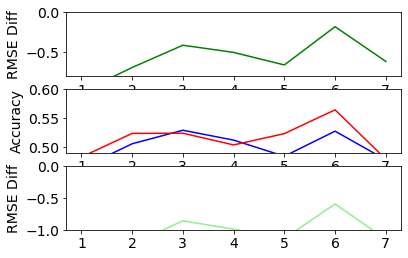

In [143]:
fig8 = plt.figure()
_ = fig8.add_subplot(3,1,1)
_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel('RMSE Diff')
_ = plt.ylim(-0.8,0)
#_ = plt.plot(np.arange(1,len(rmse)+1),rmse,color='blue')
#_ = plt.plot(np.arange(1,len(rmse)+1),bench_rmse,color='red')
_ = plt.plot(np.arange(1,len(rmse)+1),bench_rmse-rmse,color='green')
_ = fig8.add_subplot(3,1,2)
#_ = plt.xlabel('# Games Averaged')
_ = plt.ylabel('Accuracy')
_ = plt.ylim(0.49,0.60)
_ = plt.plot(np.arange(1,len(acc)+1),acc,color='blue')
_ = plt.plot(np.arange(1,len(acc)+1),acc_ext,color='red')
_ = fig8.add_subplot(3,1,3)
_ = plt.ylabel('RMSE Diff')
_ = plt.plot(np.arange(1,len(acc)+1),bench_rmse_ext-rmse_ext,color='lightgreen')
_ = plt.ylim(-1.0,-0.0)
fig8.show()
#fig8.savefig('plots/fig8.png')

In [127]:
# W/out Over/Under
path = 'data/df_working6.pkl'
with open(path, 'rb') as f:
    dfgame = pickle.load(f)
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
regress(LR,X_train,X_test,y_train,y_test,cv=5)
#metric, success = cross_valid(LR, pd.DataFrame(sca_train,index=X_train.index,columns=X_train.columns), 
#                              y_train, cv=5)

MAE_train = 10.753±0.468, Accuracy = 0.529±0.018
MAE_test = 10.966, Accuracy_test = 0.554
                LR Coefficient
H_Pts                 4.632818
matrixturf            3.287014
Wind                 -2.860109
H_Def_Pass            2.450579
V_Def_Pass            2.267395
V_Def_Rush            2.060996
V_Off_Pass            2.023017
sportturf             1.998473
V_Off_Rush            1.960890
V_TO_Lost             1.741448
V_Pass_Metric         1.740884
V_Pts_Opp            -1.738309
dome                 -1.736643
V_Rush_Metric        -1.572308
astroplay            -1.492922
V_Def_RZ_Pct          1.449259
H_RZ_Pct             -1.273984
V_Kickret             1.162670
H_Def_Rush            1.034367
H_Off_Rush           -0.956239
H_Yds_Pen             0.946898
V_RZ_Pct              0.915276
H_Pts_Opp            -0.885835
H_Sacks_Def           0.881095
a_turf               -0.838245
V_Tackles_Loss        0.811312
H_Plays               0.786742
H_TO_Lost             0.761875
H_TO_Gain  

In [322]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF Factor'] = [variance_inflation_factor(X_train.values,i) for i in range(len(X_train.columns))]
vif.round(2).sort_values(by='VIF Factor',ascending=False)

,Features,VIF Factor
2,H_Off_Pass,48.60
3,V_Off_Pass,46.83
0,H_Pts,42.16
1,V_Pts,40.62
7,V_RZ_Pct,30.47
6,H_RZ_Pct,30.04
4,H_Def_Rush,20.98
5,V_Def_Rush,20.20
8,H_Sacks_Def,11.27
9,Wind,3.11


In [38]:
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import make_scorer

In [96]:
train_ratio = 0.85

path = 'data/df_working6.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(turf,axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)

#mae, acc = cross_valid(LR, X_train, y_train, cv=5)
regress(LR,X_train,X_test,y_train,y_test,cv=5)

MAE_train = 10.717±0.425, Accuracy = 0.519±0.025
MAE_test = 10.972, Accuracy_test = 0.541
                LR Coefficient
H_Pts                 4.843906
Wind                 -2.846454
H_Def_Pass            2.478463
V_Def_Pass            2.397732
V_Def_Rush            2.116760
V_Off_Pass            2.097876
V_Off_Rush            1.934225
V_Pts_Opp            -1.795219
V_TO_Lost             1.767831
V_Pass_Metric         1.717791
V_Rush_Metric        -1.547782
V_Def_RZ_Pct          1.444680
H_RZ_Pct             -1.349561
dome                 -1.296269
V_Kickret             1.180055
H_Def_Rush            1.052673
H_Off_Rush           -0.980059
H_Yds_Pen             0.902303
H_Pts_Opp            -0.886996
H_TO_Lost             0.870915
H_TO_Gain            -0.854090
H_Sacks_Def           0.852496
V_RZ_Pct              0.844054
V_Tackles_Loss        0.841786
H_Rush_Metric         0.717059
H_TD_on_Def          -0.690746
grass                -0.646720
H_Plays               0.630843
H_FG_Pct   

In [320]:
vifdrop=['H_Poss','V_Poss','V_Plays','H_Plays','H_FG_Pct','V_FG_Pct','V_Pass_Metric',
         'V_Rush_Metric','H_Pass_Metric','H_Rush_Metric','H_Kickret','V_Kickret','Week','H_Puntret',
         'V_Puntret','H_Def_RZ_Pct','V_Def_RZ_Pct','V_Pts_Opp','H_Pts_Opp','H_Off_Rush','V_Off_Rush',
        'H_Def_Pass','V_Def_Pass','Temperature','V_Tackles_Loss','H_Tackles_Loss','H_Yds_Pen','V_Yds_Pen',
        'V_TO_Lost','H_TO_Lost','H_TO_Gain','V_TO_Gain','Humidity','V_TD_on_Def','H_TD_on_Def','V_Sacks_Def']

In [321]:
train_ratio = 0.85

path = 'data/df_working6.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(turf,axis=1)
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
print(len(X_train.columns))
regress(LR,X_train,X_test,y_train,y_test,cv=5)

12
MAE_train = 10.576±0.403, Accuracy = 0.536±0.023
MAE_test = 10.689, Accuracy_test = 0.575
             LR Coefficient
H_Pts              3.378431
V_Off_Pass         3.218525
Wind              -2.630468
dome              -2.131381
H_Off_Pass         1.684834
H_Def_Rush         1.481838
grass             -1.143125
V_Def_Rush         1.033738
H_RZ_Pct          -1.025498
V_RZ_Pct           0.818933
H_Sacks_Def        0.686804
V_Pts              0.262492


In [323]:
X_train.columns

Index(['H_Pts', 'V_Pts', 'H_Off_Pass', 'V_Off_Pass', 'H_Def_Rush',
       'V_Def_Rush', 'H_RZ_Pct', 'V_RZ_Pct', 'H_Sacks_Def', 'Wind', 'grass',
       'dome'],
      dtype='object')

In [325]:
vifdrop=['H_Poss','V_Poss','V_Plays','H_Plays','H_FG_Pct','V_FG_Pct','V_Pass_Metric',
         'V_Rush_Metric','H_Pass_Metric','H_Rush_Metric','H_Kickret','V_Kickret','Week','H_Puntret',
         'V_Puntret','H_Def_RZ_Pct','V_Def_RZ_Pct','V_Pts_Opp','H_Pts_Opp','H_Off_Rush','V_Off_Rush',
        'H_Def_Pass','V_Def_Pass','Temperature','V_Tackles_Loss','H_Tackles_Loss','H_Yds_Pen','V_Yds_Pen',
        'V_TO_Lost','H_TO_Lost','H_TO_Gain','V_TO_Gain','Humidity','V_TD_on_Def','H_TD_on_Def','V_Sacks_Def']
df=dfgame.drop(vifdrop,axis=1)
path = 'data/df_working6_sh.pkl'
with open(path,'wb') as f:
    pickle.dump(df,f)

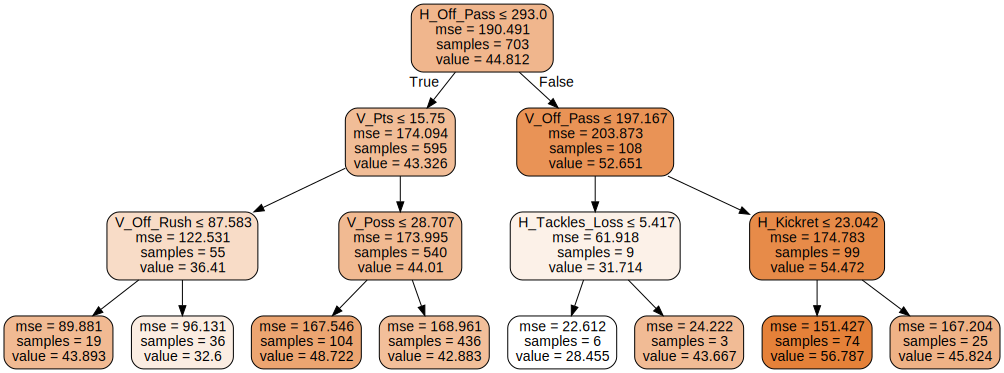

In [248]:
# No Over/Under -- Random Forest
from sklearn import ensemble
import graphviz
X = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = dfgame['Tot_Pts'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                test_size = test_ratio/(test_ratio + validation_ratio),
                                                random_state=77)
frst_model=ensemble.RandomForestRegressor(random_state=77,n_estimators=500,max_depth=3)
frst_model.fit(X_train,y_train)
y_pred = frst_model.predict(X_test)
estimator = frst_model.estimators_[20]
dot_data=tree.export_graphviz(estimator, filled=True, rounded=True,
                                     special_characters=True,feature_names=X_train.columns)
graphviz.Source(dot_data)

In [249]:
# get importance
importance = frst_model.feature_importances_
# summarize feature importance
coef = pd.DataFrame(importance, X_train.columns, columns=['Importance'])
ind=np.flip(np.argsort(importance))
coef_sort = coef.iloc[ind]
print(coef_sort)

                Importance
H_Off_Pass        0.297633
V_Off_Pass        0.139007
V_Pts             0.060716
H_Off_Rush        0.055128
V_Def_RZ_Pct      0.048678
H_Pts             0.042155
H_Pass_Metric     0.035994
V_Def_Pass        0.031543
Temperature       0.026151
V_RZ_Pct          0.024155
Wind              0.023822
H_Def_RZ_Pct      0.018751
V_Def_Rush        0.013130
V_Pts_Opp         0.013073
V_Kickret         0.012328
H_Kickret         0.011993
H_Def_Rush        0.010669
V_TO_Gain         0.009746
V_Pass_Metric     0.008337
V_Tackles_Loss    0.007540
V_Rush_Metric     0.007514
V_Yds_Pen         0.006625
H_Sacks_Def       0.006165
Humidity          0.006154
H_Puntret         0.006063
H_TO_Gain         0.005986
V_Off_Rush        0.005754
H_Yds_Pen         0.005508
H_Pts_Opp         0.005360
H_Rush_Metric     0.005239
H_FG_Pct          0.005202
V_Poss            0.004755
V_FG_Pct          0.004312
H_Poss            0.003761
V_Plays           0.003621
H_TO_Lost         0.003540
V

In [38]:
by_home = pd.DataFrame(index=teams.keys())
grouped_by_home = dfall.groupby(dfall['Home_Team'])
for key, item in grouped_by_home:
    by_home.loc[key,'Avg_Total_Points'] = item.Tot_Pts.mean()
    by_home.loc[key,'Std_Total_Points'] = item.Tot_Pts.std()
    by_home.loc[key,'Avg_Passing_Yds'] = item.H_Off_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Yds'] = item.H_Off_Rush.mean()
    by_home.loc[key,'Avg_Passing_Def'] = item.H_Def_Pass.mean()
    by_home.loc[key,'Avg_Rushing_Def'] = item.H_Def_Rush.mean()
by_home['Avg_Total_Yds'] = by_home['Avg_Passing_Yds'] + by_home['Avg_Rushing_Yds']
by_home['Avg_Total_Def'] = by_home['Avg_Passing_Def'] + by_home['Avg_Rushing_Def']
by_home['Passing_Rank'] = by_home['Avg_Passing_Yds'].rank(ascending=False)
by_home['Rushing_Rank'] = by_home['Avg_Rushing_Yds'].rank(ascending=False)
by_home['Offense_Rank'] = by_home['Avg_Total_Yds'].rank(ascending=False)
by_home['Passing_Def_Rank'] = by_home['Avg_Passing_Def'].rank(ascending=False)
by_home['Rushing_Def_Rank'] = by_home['Avg_Rushing_Def'].rank(ascending=False)
by_home['Defense_Rank'] = by_home['Avg_Total_Def'].rank(ascending=False)
by_home = by_home.drop(['Avg_Passing_Yds','Avg_Rushing_Yds','Avg_Total_Yds',
                        'Avg_Passing_Def','Avg_Rushing_Def','Avg_Total_Def'],axis=1)

by_home.index.name='Team'
by_home=by_home.sort_values(by=['Avg_Total_Points'],ascending=False)
by_home.reset_index(drop=False,inplace=True)

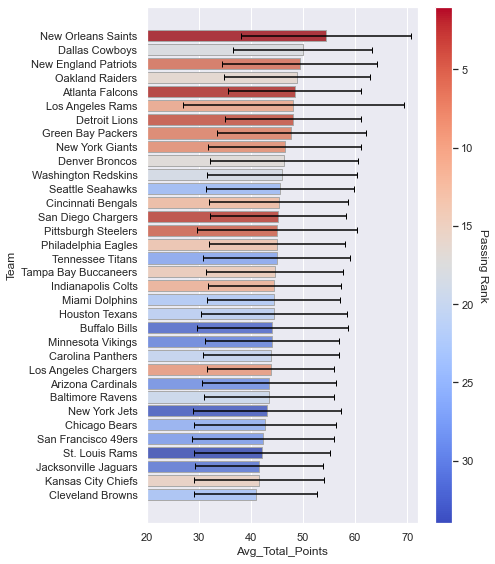

In [935]:
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(7,8))
ax = fig11.add_subplot(1,1,1)
_ = plt.xlabel('Average Total Points')
_ = plt.ylabel('Team')
_ = plt.xlim(20,72)
sns.set(font_scale=1.0)
sns.barplot(x='Avg_Total_Points',y='Team',data=by_home,edgecolor='darkgray',
            palette=colors_from_values(by_home['Passing_Rank'],'coolwarm_r'))
plt.errorbar(by_home['Avg_Total_Points'],by_home['Team'],xerr=by_home['Std_Total_Points'],color='black',linestyle='None',capsize=3)
sm = ScalarMappable(cmap='coolwarm_r', norm=plt.Normalize(34,1))
sm.set_array([])
cbar = plt.colorbar(sm,label='Passing Rank',aspect=30)
cbar.ax.invert_yaxis()
cbar.set_label('Passing Rank',rotation=270,labelpad=15)
fig.tight_layout()
fig.show()

In [391]:
tmpts = pd.DataFrame(index=pd.MultiIndex.from_product([teams.keys(),range(160)],
                                                    names=['Team','Game']),columns=['Points','Location'])
tmpts.sort_index(ascending=True, inplace=True)
for team in tmpts.index.levels[0]:
    home_games = len(dfall[dfall.Home_Team==team])
    tmpts.loc[(team,slice(0,home_games-1)),'Points'] = dfall.loc[dfall.Home_Team==team,'H_Game'].values
    tmpts.loc[(team,slice(0,home_games-1)),'Location'] = 'H'
    vis_games = len(dfall[dfall.Vis_Team==team])
    tmpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Points'] = \
        dfall.loc[dfall.Vis_Team==team,'V_Game'].values
    tmpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Location'] = 'A'
tmpts['Points'] = pd.to_numeric(tmpts['Points'])
tmpts = tmpts.reset_index(drop=False)
tmpts.loc[tmpts.Location=='H','mean_H']=tmpts[tmpts.Location=='H'].groupby('Team')['Points'].transform(np.mean)
tmpts.loc[tmpts.Location=='H','mean_A']=0
tmpts.loc[tmpts.Location=='A','mean_A']=tmpts[tmpts.Location=='A'].groupby('Team')['Points'].transform(np.mean)
tmpts.loc[tmpts.Location=='A','mean_H']=0
tmpts['mean_diff']=tmpts['mean_H']-tmpts['mean_A']
tmpts['meaned']=tmpts.groupby('Team')['mean_diff'].transform(np.mean)*2.0
tmpts=tmpts.sort_values('meaned',ascending=False).drop(['mean_H','mean_A','mean_diff','meaned'],axis=1)

In [390]:
totpts = pd.DataFrame(index=pd.MultiIndex.from_product([teams.keys(),range(160)],
                                                    names=['Team','Game']),columns=['Tot_Pts','Location'])
totpts.sort_index(ascending=True, inplace=True)
for team in totpts.index.levels[0]:
    home_games = len(dfall[dfall.Home_Team==team])
    totpts.loc[(team,slice(0,home_games-1)),'Tot_Pts'] = dfall.loc[dfall.Home_Team==team,'Tot_Pts'].values
    totpts.loc[(team,slice(0,home_games-1)),'Location'] = 'H'
    vis_games = len(dfall[dfall.Vis_Team==team])
    totpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Tot_Pts'] = \
        dfall.loc[dfall.Vis_Team==team,'Tot_Pts'].values
    totpts.loc[(team,slice(home_games,home_games+vis_games-1)),'Location'] = 'A'
totpts['Tot_Pts'] = pd.to_numeric(totpts['Tot_Pts'])
totpts = totpts.reset_index(drop=False)
totpts.loc[totpts.Location=='H','mean_H']=totpts[totpts.Location=='H'].groupby('Team')['Tot_Pts'].transform(np.mean)
totpts.loc[totpts.Location=='H','mean_A']=0
totpts.loc[totpts.Location=='A','mean_A']=totpts[totpts.Location=='A'].groupby('Team')['Tot_Pts'].transform(np.mean)
totpts.loc[totpts.Location=='A','mean_H']=0
totpts['mean_diff']=totpts['mean_H']-totpts['mean_A']
totpts['meaned']=totpts.groupby('Team')['mean_diff'].transform(np.mean)*2.0
totpts=totpts.sort_values('meaned',ascending=False).drop(['mean_H','mean_A','mean_diff','meaned'],axis=1)

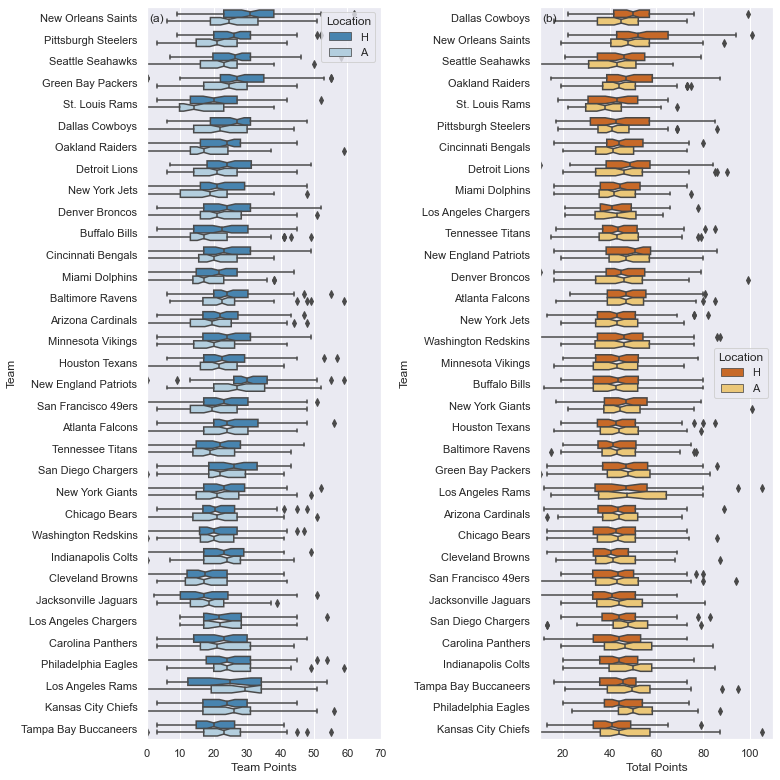

In [331]:
fig11 = plt.figure(figsize=(11,11))
ax1 = fig11.add_subplot(1,2,1)
_ = plt.xlabel('Team Points')
_ = plt.ylabel('Team')
_ = plt.xlim(0,70)
sns.set(font_scale=1.0)
sns.boxplot(x='Points',y='Team',hue='Location',hue_order=['H','A'],data=tmpts,palette='Blues_r',width=0.7,notch='Yes').set(xlabel='Team Points')
_ = plt.text(0.01,0.98,'(a)',transform=ax1.transAxes,fontsize='medium')
ax2 = fig11.add_subplot(1,2,2)
_ = plt.xlabel('Total Points')
_ = plt.ylabel('Team')
_ = plt.xlim(10,110)
sns.set(font_scale=1.0)
sns.boxplot(x='Tot_Pts',y='Team',hue='Location',hue_order=['H','A'],data=totpts,palette='YlOrBr_r',width=0.7,notch='Yes').set(xlabel='Total Points')
_ = plt.text(0.01,0.98,'(b)',transform=ax2.transAxes,fontsize='medium')
fig11.tight_layout()
fig11.show()
fig11.savefig('plots/fig11.png')

In [36]:
saints=dfall[(dfall.Home_Team=='New Orleans Saints') | (dfall.Vis_Team=='New Orleans Saints')]
print((((saints.Home_Team=='New Orleans Saints')&(saints.H_Game>saints.V_Game))|
      ((saints.Vis_Team=='New Orleans Saints')&(saints.V_Game>saints.H_Game))).mean())
print(((saints.Home_Team=='New Orleans Saints')&(saints.H_Game>saints.V_Game)).sum()/
     (saints.Home_Team=='New Orleans Saints').sum())

0.625
0.6875


In [448]:
names=['Dallas Cowboys','New Orleans Saints','Seattle Seahawks','Oakland Raiders','Pittsburgh Steelers',
      'Cincinnati Bengals','Detroit Lions','Miami Dolphins']
pts = pd.DataFrame(index=pd.MultiIndex.from_product(
    [names,range(160)],names=['Team','Game']),columns=['Tot_Pts','Over_Under','Location'])
pts.sort_index(ascending=True, inplace=True)
for team in pts.index.levels[0]:
    home_games = len(dfall[dfall.Home_Team==team])
    pts.loc[(team,slice(0,home_games-1)),'Tot_Pts'] = dfall.loc[dfall.Home_Team==team,'Tot_Pts'].values
    pts.loc[(team,slice(0,home_games-1)),'Over_Under'] = dfall.loc[dfall.Home_Team==team,'Over/Under'].values
    pts.loc[(team,slice(0,home_games-1)),'Location'] = 'H'
    vis_games = len(dfall[dfall.Vis_Team==team])
    pts.loc[(team,slice(home_games,home_games+vis_games-1)),'Tot_Pts'] = \
        dfall.loc[dfall.Vis_Team==team,'Tot_Pts'].values
    pts.loc[(team,slice(home_games,home_games+vis_games-1)),'Over_Under'] = \
        dfall.loc[dfall.Vis_Team==team,'Over/Under'].values
    pts.loc[(team,slice(home_games,home_games+vis_games-1)),'Location'] = 'A'
pts['Tot_Pts'] = pd.to_numeric(pts['Tot_Pts'])
pts['Over_Under'] = pd.to_numeric(pts['Over_Under'])
pts.loc[pts.Location=='H','mean_TP_H']=pts[pts.Location=='H'].groupby('Team')['Tot_Pts'].transform(np.mean)
pts.loc[pts.Location=='H','mean_TP_A']=0
pts.loc[pts.Location=='H','mean_OU_H']=pts[pts.Location=='H'].groupby('Team')['Over_Under'].transform(np.mean)
pts.loc[pts.Location=='H','mean_OU_A']=0
pts.loc[pts.Location=='A','mean_TP_A']=pts[pts.Location=='A'].groupby('Team')['Tot_Pts'].transform(np.mean)
pts.loc[pts.Location=='A','mean_TP_H']=0
pts.loc[pts.Location=='A','mean_OU_A']=pts[pts.Location=='A'].groupby('Team')['Over_Under'].transform(np.mean)
pts.loc[pts.Location=='A','mean_OU_H']=0
pts['md_TP']=pts['mean_TP_H']-pts['mean_TP_A']
pts['md_OU']=pts['mean_OU_H']-pts['mean_OU_A']
pts['diff_TP']=pts.groupby('Team')['md_TP'].transform(np.mean)*2.0
pts['diff_OU']=pts.groupby('Team')['md_OU'].transform(np.mean)*2.0

pts = pts.reset_index()
mdpts=pd.DataFrame(index=pts.Team.unique(),columns=['Mean_Diff_TP','Mean_Diff_OU'])
for team,df in pts.groupby('Team'):
    mdpts.loc[team,'Mean_Diff_TP']=df['diff_TP'].mean()
    mdpts.loc[team,'Mean_Diff_OU']=df['diff_OU'].mean()
print(mdpts)
pts=pts.drop(['Game','mean_TP_H','mean_TP_A','mean_OU_H','mean_OU_A','md_TP','md_OU','diff_TP','diff_OU'],axis=1)
melted = pts.melt(id_vars=['Team','Location'])
melted['var']=melted['variable']+'_'+melted['Location']
melted = melted.drop(['variable','Location'],axis=1).rename({'var':'variable'},axis=1)

                    Mean_Diff_TP Mean_Diff_OU
Cincinnati Bengals          2.75      0.01875
Dallas Cowboys             6.225       0.9375
Detroit Lions             2.6375      1.04375
Miami Dolphins             2.075      -0.2625
New Orleans Saints           5.3      0.61875
Oakland Raiders            3.925          0.3
Pittsburgh Steelers         3.45       0.1875
Seattle Seahawks           4.575      -0.0625


In [466]:
over = pd.DataFrame(index=names,columns=['Home_Over','Away_Over'])
for team in over.index:
    df = pts[((pts['Team']==team) & (pts['Location']=='H'))]
    over.loc[team,'Home_Over'] = (df['Tot_Pts'] > df['Over_Under']).mean()
    df = pts[((pts['Team']==team) & (pts['Location']=='A'))]
    over.loc[team,'Away_Over'] = (df['Tot_Pts'] > df['Over_Under']).mean()

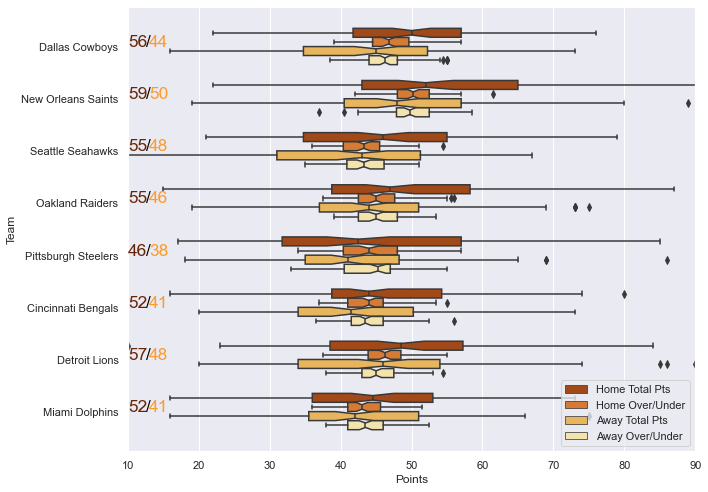

In [467]:
fig13 = plt.figure(figsize=(10,7))
_ = plt.xlabel('Points')
_ = plt.xlim(10,90)
sns.set(font_scale=1.0)
ax = sns.boxplot(x='value',y='Team',hue='variable',hue_order=['Tot_Pts_H','Over_Under_H','Tot_Pts_A','Over_Under_A'],
            data=melted,palette='YlOrBr_r',width=0.7,notch='Yes',order=names)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Home Total Pts','Home Over/Under','Away Total Pts','Away Over/Under'])
ax.set(xlabel='Points')
ax.margins(0.05)
COL = MplColorHelper('YlOrBr_r', 0, 10)
for y in range(len(names)):
    _ = plt.text(10,y,'{:d}'.format(round(over.loc[names[y],'Home_Over']*100)),
                 c=COL.get_rgb(0),fontsize='x-large')
    _ = plt.text(12.5,y,'/',c='black',fontsize='x-large')
    _ = plt.text(13,y,'{:d}'.format(round(over.loc[names[y],'Away_Over']*100)),
                 c=COL.get_rgb(5),fontsize='x-large')
fig13.tight_layout()
fig13.show()
fig13.savefig('plots/fig13.png')

In [ ]:
res = pg.ttest(early['Tot_Pts']>early['Over/Under'],late['Tot_Pts']>late['Over/Under'],
               correction=True,tail='two-sided')
print(res)

In [ ]:
tpmean = (domed['Tot_Pts'].mean(),
          outside[(outside['Wind']<=5)]['Tot_Pts'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Tot_Pts'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Tot_Pts'].mean(),
          outside[(outside['Wind']>20)]['Tot_Pts'].mean())
oumean = (domed['Over/Under'].mean(),
          outside[(outside['Wind']<=5)]['Over/Under'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Over/Under'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Over/Under'].mean(),
          outside[(outside['Wind']>20)]['Over/Under'].mean())

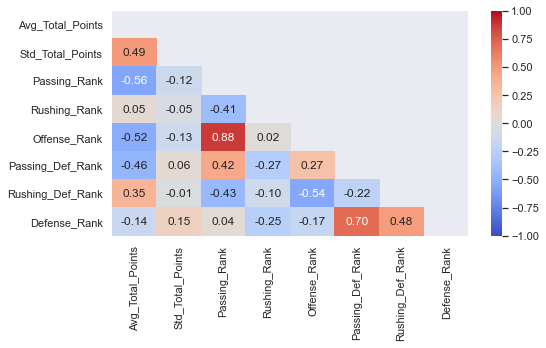

In [804]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

mask = np.triu(by_home.corr())
sns.heatmap(by_home.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            cmap='coolwarm',annot=True,fmt='.2f')
fig.tight_layout()
fig.show()
fig.savefig('plots/fig98.png')

In [99]:
by_week = dfall[['Tot_Pts','Temperature']]
for ind in by_week.index: 
    by_week.loc[ind,'Week_Beg'] = weekofgame(ind)
    by_week.loc[ind,'Year'] = get_year(ind)
grouped_by_year = by_week.groupby(by_week['Year'])
for key, item in grouped_by_year:
    mapping = get_mapping(item,1)
    for code in item.index:
        by_week.loc[code,'Week'] = int(mapping[by_week.loc[code,'Week_Beg']])
by_week['Week'] = by_week['Week'].astype('int')

In [100]:
avg_pts_week = by_week['Tot_Pts'].groupby(by_week['Week']).mean()
avg_temp_week = by_week['Temperature'].groupby(by_week['Week']).mean()

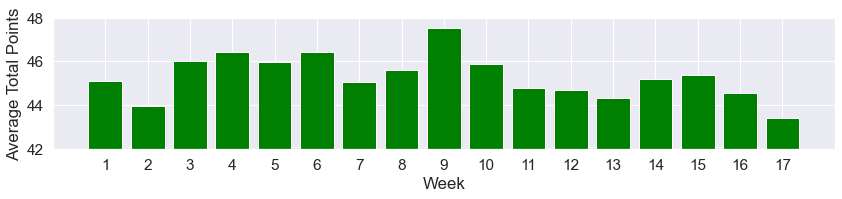

In [102]:
fig9 = plt.figure(figsize=(12,3))
_ = fig9.add_subplot(1,1,1)
_ = plt.xlabel('Week')
_ = plt.ylabel('Average Total Points')
_ = plt.ylim(42,48)
_ = plt.bar(avg_pts_week.index,avg_pts_week.values,color='green',
       tick_label=[str(i) for i in range(1,18)])
#ax2 = ax.twinx()
#ax2.set_ylabel('Temperature (°F)')
#ax2.set_ylim(50,70)
#ax2.plot(avg_temp_week.index,avg_temp_week.values,linewidth=1, color='blue')
#_ = fig9.add_subplot(1,1,1)
#_ = plt.bar()
fig9.tight_layout()  
fig9.show()

In [887]:
domed = dfall[dfall['dome'] == 1]
outside = dfall[dfall['dome'] == 0]

In [888]:
len(domed)/len(dfall)

0.2629933567799922

In [822]:
temp = notdomed[['Tot_Pts','Temperature']]
#bins = [i for i in range(0,91,10)]
#bins.remove(10)
bins = [-10,30,40,50,60,70,80,100]
grouped = temp.groupby(pd.cut(temp.Temperature,bins))
ind = np.arange(len(grouped['Tot_Pts'].mean()))
print(grouped['Tot_Pts'].mean(),grouped['Tot_Pts'].count())
type(grouped['Tot_Pts'].mean())

Temperature
(-10, 30]    43.725000
(30, 40]     44.138889
(40, 50]     44.528302
(50, 60]     44.914706
(60, 70]     45.847887
(70, 80]     44.831373
(80, 100]    43.824324
Name: Tot_Pts, dtype: float64 Temperature
(-10, 30]    160
(30, 40]     180
(40, 50]     159
(50, 60]     340
(60, 70]     355
(70, 80]     255
(80, 100]    148
Name: Tot_Pts, dtype: int64


pandas.core.series.Series

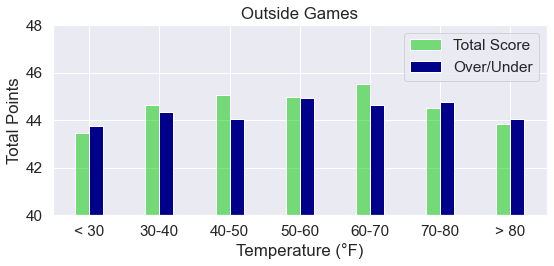

In [909]:
tpmean = (outside[(outside['Temperature']<=30)]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>30) & (outside['Temperature']<=40))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>40) & (outside['Temperature']<=50))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>50) & (outside['Temperature']<=60))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>60) & (outside['Temperature']<=70))]['Tot_Pts'].mean(),
          outside[((outside['Temperature']>70) & (outside['Temperature']<=80))]['Tot_Pts'].mean(),
          outside[(outside['Temperature']>80)]['Tot_Pts'].mean())
oumean = (outside[(outside['Temperature']<=30)]['Over/Under'].mean(),
          outside[((outside['Temperature']>30) & (outside['Temperature']<=40))]['Over/Under'].mean(),
          outside[((outside['Temperature']>40) & (outside['Temperature']<=50))]['Over/Under'].mean(),
          outside[((outside['Temperature']>50) & (outside['Temperature']<=60))]['Over/Under'].mean(),
          outside[((outside['Temperature']>60) & (outside['Temperature']<=70))]['Over/Under'].mean(),
          outside[((outside['Temperature']>70) & (outside['Temperature']<=80))]['Over/Under'].mean(),
          outside[(outside['Temperature']>80)]['Over/Under'].mean())

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)

ind = np.arange(7)  # the x locations for the groups
width = 0.2  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score',color=(0,0.8,0,0.5))
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under',color='darkblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Total Points')
#_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.xlabel('Temperature (°F)')
_ = plt.title('Outside Games')
_ = plt.legend(loc='upper right')
_ = plt.ylim(40,48)
fig.tight_layout()
fig.show()

In [898]:
(outside[(outside['Temperature']<=30)]['Tot_Pts'].count(),
          outside[((outside['Temperature']>30) & (outside['Temperature']<=40))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>40) & (outside['Temperature']<=50))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>50) & (outside['Temperature']<=60))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>60) & (outside['Temperature']<=70))]['Tot_Pts'].count(),
          outside[((outside['Temperature']>70) & (outside['Temperature']<=80))]['Tot_Pts'].count(),
          outside[(outside['Temperature']>80)]['Tot_Pts'].count())

(172, 207, 188, 377, 434, 320, 188)

In [786]:
gr_by_t['Tot_Pts'].count()

Wind
(0, 5]      525
(5, 10]     782
(10, 20]    462
(20, 80]     35
Name: Tot_Pts, dtype: int64

In [805]:
domed = dfall[dfall['dome']==1]
outside = dfall[dfall['dome']==0]

In [911]:
outside[(outside['Wind']<=5)]['Tot_Pts'].mean()

46.237232289950576

In [912]:
outside[(outside['Wind']<=5)]['Over/Under'].mean()

44.78665568369028

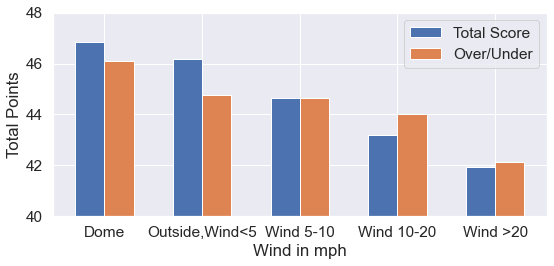

In [872]:
tpmean = (domed['Tot_Pts'].mean(),
          outside[(outside['Wind']<=5)]['Tot_Pts'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Tot_Pts'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Tot_Pts'].mean(),
          outside[(outside['Wind']>20)]['Tot_Pts'].mean())
oumean = (domed['Over/Under'].mean(),
          outside[(outside['Wind']<=5)]['Over/Under'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Over/Under'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Over/Under'].mean(),
          outside[(outside['Wind']>20)]['Over/Under'].mean())

fig10 = plt.figure(figsize=(8,4))
ax = fig10.add_subplot(1,1,1)

ind = np.arange(5)  # the x locations for the groups
width = 0.3  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Total Points')
#_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside,Wind<5','Wind 5-10','Wind 10-20','Wind >20'))
_ = plt.xlabel('Wind in mph')
_ = plt.legend(loc='upper right')
_ = plt.ylim(40,48)
fig10.show()
fig10.tight_layout()
fig10.savefig('plots/fig10.png')

In [847]:
dfout=dfall[['Tot_Pts','Over/Under','dome','Wind']]
dfout.loc[dfout['dome']==1,'Desc'] = 'Dome'
dfout.loc[((dfout['dome']==0)&(dfout['Wind']<5)),'Desc'] = 'Outside,Wind<5'
dfout.loc[((dfout['Wind']>=5)&(dfout['Wind']<10)),'Desc'] = 'Wind 5-10'
dfout.loc[((dfout['Wind']>=10)&(dfout['Wind']<20)),'Desc'] = 'Wind 10-20'
dfout.loc[(dfout['Wind']>=20),'Desc'] = 'Wind >20'
dfout.drop(['dome','Wind'],axis=1,inplace=True)
dfout=pd.melt(dfout,id_vars=['Desc'],value_vars=['Tot_Pts','Over/Under'],
              var_name='Feature')

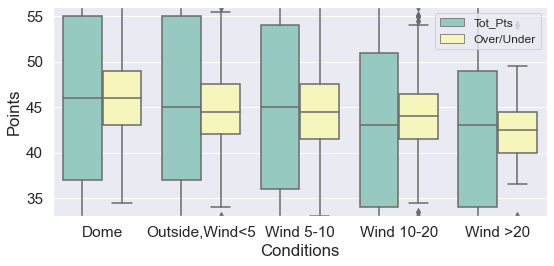

In [870]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
_ = sns.boxplot(x='Desc',y='value',hue='Feature',data=dfout,orient='v',palette='Set3',
           order=['Dome','Outside,Wind<5','Wind 5-10','Wind 10-20','Wind >20']).set(xlabel='Conditions',
                                                                                    ylabel='Points',
                                                                                    ylim=(33,56))
_ = ax.legend(loc='upper right',fontsize=12)
_ = fig.tight_layout()
_ = fig.show()

                     Mean_Home_Wind Mean_Away_Wind  Home_Over  Away_Over
Cleveland Browns            12.7625         6.2375  41.250000   48.75000
Miami Dolphins                 11.2            6.7  52.500000   41.25000
Buffalo Bills               10.2875         7.2875  51.250000   45.00000
Chicago Bears                   9.9         5.3875  46.250000   52.50000
Philadelphia Eagles           9.375         5.0375  42.500000   61.25000
Green Bay Packers            9.0625         5.2375  52.500000   53.75000
Pittsburgh Steelers           8.675         7.8125  46.250000   37.50000
Kansas City Chiefs           8.5375          5.875  36.250000   50.00000
New England Patriots        8.53165            7.2  59.493671   48.75000
Oakland Raiders              8.4375         7.0375  55.000000   46.25000
New York Jets                8.1625        8.82278  51.250000   54.43038
Tampa Bay Buccaneers          8.125            3.7  47.500000   57.50000
Baltimore Ravens             7.8375          6.975 

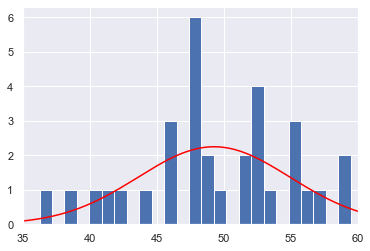

In [525]:
wind=pd.DataFrame(index=teams,columns=['Mean_Home_Wind','Mean_Away_Wind','Home_Over','Away_Over'])
for team in teams:
    if (team not in ['St. Louis Rams','San Diego Chargers']):
        if team == 'Los Angeles Rams':
            df=pd.concat([dfall[dfall['Home_Team']==team],dfall[dfall['Home_Team']=='St. Louis Rams']])
        elif team == 'Los Angeles Chargers':
            df=pd.concat([dfall[dfall['Home_Team']==team],dfall[dfall['Home_Team']=='San Diego Chargers']])
        else:
            df=dfall[dfall['Home_Team']==team]
        wind.loc[team,'Mean_Home_Wind']=df['Wind'].mean()
        wind.loc[team,'Home_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
        df=dfall[dfall['Vis_Team']==team]
        wind.loc[team,'Mean_Away_Wind']=df['Wind'].mean()
        wind.loc[team,'Away_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
wind=wind.drop(['St. Louis Rams','San Diego Chargers'])
wind['Home_Over']=(100*pd.to_numeric(wind['Home_Over']))
wind['Away_Over']=(100*pd.to_numeric(wind['Away_Over']))
wind = wind.sort_values(by='Mean_Home_Wind',ascending=False)
print(wind)
plt.hist(wind['Home_Over'],bins=25)
plt.xlim(35,60)
xx = np.linspace(35,65,500)
yy = len(wind)*stats.norm.pdf(xx,loc=np.mean(wind['Home_Over']),scale=np.std(wind['Home_Over']))
plt.plot(xx,yy,c='red')
plt.show()

In [485]:
wind=pd.DataFrame(index=teams,columns=['Mean_Home_Wind','Mean_Away_Wind','Home_Over','Away_Over'])
for team in teams:
    df=dfall[dfall['Home_Team']==team]
    wind.loc[team,'Mean_Home_Wind']=df['Wind'].mean()
    wind.loc[team,'Home_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
    df=dfall[dfall['Vis_Team']==team]
    wind.loc[team,'Mean_Away_Wind']=df['Wind'].mean()
    wind.loc[team,'Away_Over']=(df['Tot_Pts']>df['Over/Under']).mean()
wind['Home_Over']=(100*pd.to_numeric(wind['Home_Over']))
wind['Away_Over']=(100*pd.to_numeric(wind['Away_Over']))
wind = wind.sort_values(by='Mean_Home_Wind',ascending=False)
print(wind)

                     Mean_Home_Wind Mean_Away_Wind  Home_Over  Away_Over
Cleveland Browns            12.7625         6.2375  41.250000  48.750000
Miami Dolphins                 11.2            6.7  52.500000  41.250000
Buffalo Bills               10.2875         7.2875  51.250000  45.000000
Chicago Bears                   9.9         5.3875  46.250000  52.500000
Philadelphia Eagles           9.375         5.0375  42.500000  61.250000
Green Bay Packers            9.0625         5.2375  52.500000  53.750000
Pittsburgh Steelers           8.675         7.8125  46.250000  37.500000
Kansas City Chiefs           8.5375          5.875  36.250000  50.000000
New England Patriots        8.53165            7.2  59.493671  48.750000
Oakland Raiders              8.4375         7.0375  55.000000  46.250000
New York Jets                8.1625        8.82278  51.250000  54.430380
Tampa Bay Buccaneers          8.125            3.7  47.500000  57.500000
Baltimore Ravens             7.8375          6.975 

In [540]:
wind['Home_Over'].std()

5.77247204142507

In [541]:
kc = dfall[dfall['Home_Team']=='Kansas City Chiefs']
(kc['Tot_Pts']<kc['Over/Under']).mean()

0.625

In [535]:
ser=pd.Series(index=teams)
for team in teams:
    home = dfall[dfall.Home_Team==team]
    away = dfall[dfall.Vis_Team==team]
    diff = home['Over/Under'].mean() - away['Over/Under'].mean()
    ser[team] = abs(diff)
print(ser.sort_values(ascending=False))
print(ser.mean())

Green Bay Packers       1.087500
Detroit Lions           1.043750
Dallas Cowboys          0.937500
Atlanta Falcons         0.843750
Washington Redskins     0.712500
New Orleans Saints      0.618750
Kansas City Chiefs      0.506250
Indianapolis Colts      0.481250
Buffalo Bills           0.418750
Los Angeles Chargers    0.375000
San Francisco 49ers     0.368750
Baltimore Ravens        0.356250
New York Jets           0.356013
Cleveland Browns        0.312500
San Diego Chargers      0.312500
Oakland Raiders         0.300000
St. Louis Rams          0.281250
Minnesota Vikings       0.268750
Miami Dolphins          0.262500
Tampa Bay Buccaneers    0.256250
Los Angeles Rams        0.250000
Carolina Panthers       0.231250
Denver Broncos          0.212500
New England Patriots    0.209968
Pittsburgh Steelers     0.187500
Chicago Bears           0.106250
New York Giants         0.100000
Jacksonville Jaguars    0.075000
Seattle Seahawks        0.062500
Philadelphia Eagles     0.050000
Tennessee 

In [511]:
import pingouin as pg
res = pg.ttest(ntot_home['Tot_Pts']>ntot_home['Over/Under'],(dfall['Tot_Pts']>dfall['Over/Under']).mean(),
              tail='one-sided')
print(res)

              T  dof     tail     p-val       CI95%   cohen-d  BF10     power
T-test  1.71034   79  greater  0.045564  [0.5, inf]  0.191222  0.99  0.520263


22%


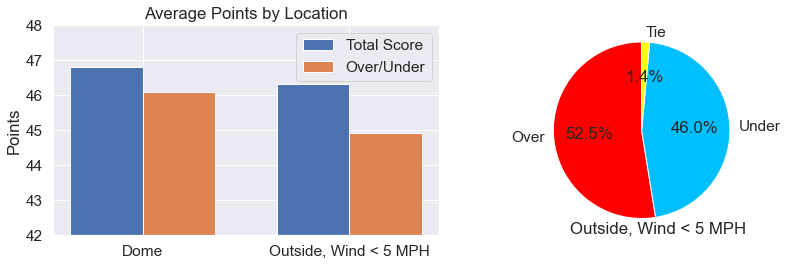

In [913]:
tpmean = (dfall[dfall['dome']==1]['Tot_Pts'].mean(),dfall[(dfall['dome']==0)&(dfall['Wind'] < 5)]['Tot_Pts'].mean())
oumean = (dfall[dfall['dome']==1]['Over/Under'].mean(),dfall[(dfall['dome']==0)&(dfall['Wind'] < 5)]['Over/Under'].mean())

o_u = np.array([(outside[outside['Wind']<5]['Tot_Pts'] > outside[outside['Wind']<5]['Over/Under']).sum(),
                (outside[outside['Wind']<5]['Tot_Pts'] < outside[outside['Wind']<5]['Over/Under']).sum(),
                 (outside[outside['Wind']<5]['Tot_Pts']==outside[outside['Wind']<5]['Over/Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')

fig95 = plt.figure(figsize=(12,4))
_ = fig95.add_subplot(1,2,1)

ind = np.arange(2)  # the x locations for the groups
width = 0.35  # the width of the bars

#sns.set(font_scale=1.0)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Points')
_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside, Wind < 5 MPH'))
_ = plt.legend(loc='upper right')
_ = plt.ylim(42,48)

ax2 = fig95.add_subplot(1,2,2)
_ = plt.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.05,colors=colors,
        startangle=90)
ax2.text(0.16,0.01,'Outside, Wind < 5 MPH',transform=ax2.transAxes)
fig95.tight_layout()
fig95.show()
pct=round(len(dfall[(dfall['dome']==0)&(dfall['Wind'] < 5)])/len(dfall[(dfall['dome']==0)])*100)
print(f'{pct:2d}%')
fig95.savefig('plots/fig95.png')

In [889]:
domed['Home_Team'].unique()

array(['Atlanta Falcons', 'New Orleans Saints', 'St. Louis Rams',
       'Buffalo Bills', 'Minnesota Vikings', 'Dallas Cowboys',
       'Detroit Lions', 'Indianapolis Colts', 'Arizona Cardinals',
       'Houston Texans'], dtype=object)

In [892]:
len(domed)/len(dfall)

0.2629933567799922

In [893]:
domed['Tot_Pts'].mean(),outside['Tot_Pts'].mean()

(46.809806835066865, 44.74496288441145)

In [896]:
domed['Over/Under'].mean(),outside['Over/Under'].mean()

(46.091381872213965, 44.490721102863205)

In [454]:
(domed['Tot_Pts'] > domed['Over/Under']).mean()

0.5026548672566372

In [398]:
print(tpmean[1])

47.24175824175824


In [691]:
outside_means=bootstrap(dfall['Tot_Pts']>dfall['Over/Under'],365,np.mean)

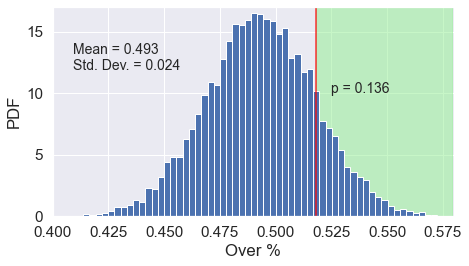

In [842]:
mu = np.mean(outside_means)
sd = np.std(outside_means)
pct2_5 = np.percentile(outside_means,2.5)
pct97_5 = np.percentile(outside_means,97.5)
x = np.arange(0.518,0.58,0.001)
ymax = 17.0
y1 = ymax
y2 = 0.0
fig78 = plt.figure(figsize=(7,4))
ax = fig78.add_subplot(1,1,1)
_ = plt.hist(outside_means,bins=57,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
_ = plt.xlim(0.40,0.58)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
p = 1.0-stats.percentileofscore(outside_means,0.518)/100
ax.text(0.525,10,'p = {:.3f}'.format(p),fontsize='small')
#ax.text(0.05,0.2,'95% Conf. Int. =\n [{0:.3f},{1:.3f}]'.format(pct2_5,pct97_5),
#                                                               transform=ax.transAxes,fontsize='small')
ax.fill_between(x, y1, y2,color='lightgreen',alpha=0.5)
#_ = plt.vlines(pct2_5,0,ymax,color='red',alpha=0.8)
_ = plt.vlines(0.518,0,ymax,color='red',alpha=0.8)
#_ = plt.scatter(outside_count.values[0],0.4,marker='.',color='red',s=200,zorder=2)
_ = plt.xlabel('Over %')
_ = plt.ylabel('PDF')
fig78.tight_layout()
plt.show()
fig78.savefig('plots/fig78.png')

In [705]:
notdomed['Tot_Pts'].corr(notdomed['Temperature'])

0.04175134613588856

In [714]:
notdomed['Tot_Pts'].corr(notdomed['Temperature']**(0.5))

0.056523605587800195

In [703]:
test = notdomed[notdomed['Temperature']<65]
test['Tot_Pts'].corr(test['Temperature'])

0.06161124098270196

In [702]:
test = notdomed[notdomed['Temperature']>=65]
test['Tot_Pts'].corr(test['Temperature'])

-0.10142750464523927

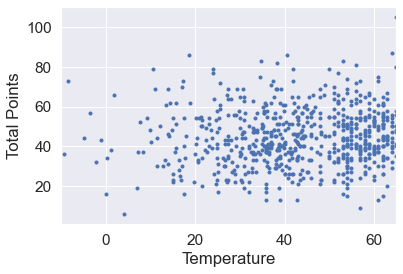

In [694]:
_ = plt.plot(notdomed['Temperature'],notdomed['Tot_Pts'],marker='.',linestyle="None")
_ = plt.xlim(-10,65)
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Total Points')
plt.show()

In [382]:
X_show['Wind'].describe()

count    1098.000000
mean        6.310565
std         6.297769
min         0.000000
25%         0.000000
50%         6.000000
75%        10.000000
max        71.000000
Name: Wind, dtype: float64

In [664]:
X_show[X_show['Wind']==71]

,Home_Team,Vis_Team,H_Game,V_Game,Tot_Pts,Over/Under,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,...,Temperature,Wind,a_turf,astroplay,astroturf,fieldturf,grass,matrixturf,sportturf,Week
Code,,,,,,,,,,,,,,,,,,,,,
201612040pit,Pittsburgh Steelers,New York Giants,24.0,14.0,38,49.5,21.166667,21.5,23.666667,17.5,...,28.113559,71.0,0,0,0,0,1,0,0,13


In [262]:
surf_cols=['a_turf','astroplay','fieldturf','grass','matrixturf','sportturf']
X_show['astroturf'] = 1-X_show[surf_cols].sum(axis=1)
surf_cols.append('astroturf')
surface = pd.concat([X_show[['Tot_Pts']],X_show[surf_cols]],axis=1)
by_surface = combine_dummies(surface,'surface',surf_cols)
avg_pts_surf=by_surface['Tot_Pts'].groupby(by_surface['surface']).mean()

In [263]:
count_surf = by_surface['Tot_Pts'].groupby(by_surface['surface']).count()
count_surf

surface
a_turf         31
astroplay      25
astroturf      18
fieldturf     293
grass         619
matrixturf     31
sportturf      81
Name: Tot_Pts, dtype: int64

In [389]:
by_team = pd.DataFrame(index=teams.keys())
grouped_by_home = dfall.groupby(dfall['Home_Team'])
grouped_by_vis = dfall.groupby(dfall['Vis_Team'])
for key, item in grouped_by_home:
    by_team.loc[key,'Avg Home Team Score'] = round(item['H_Game'].mean(),3)
    by_team.loc[key,'Avg Home Total Score'] = round(item['Tot_Pts'].mean(),3)
for key,item in grouped_by_vis:
    by_team.loc[key,'Avg Vis Team Score'] = round(item['V_Game'].mean(),3)
    by_team.loc[key,'Avg Vis Total Score'] = round(item['Tot_Pts'].mean(),3)
by_team['Avg Team Score'] = (by_team['Avg Home Team Score'] + by_team['Avg Vis Team Score'])/2.0
by_team['Team Home - Vis'] = by_team['Avg Home Team Score'] - by_team['Avg Vis Team Score']
by_team['Total Home - Vis'] = by_team['Avg Home Total Score'] - by_team['Avg Vis Total Score']
by_team = by_team[['Avg Home Team Score','Avg Vis Team Score','Avg Team Score','Team Home - Vis',
                   'Avg Home Total Score','Avg Vis Total Score','Total Home - Vis']]
by_team.sort_values(by=['Avg Team Score'],ascending=False)

,Avg Home Team Score,Avg Vis Team Score,Avg Team Score,Team Home - Vis,Avg Home Total Score,Avg Vis Total Score,Total Home - Vis
New England Patriots,30.785,28.125,29.4550,2.660,49.392,47.812,1.580
New Orleans Saints,30.625,25.550,28.0875,5.075,54.350,49.050,5.300
Green Bay Packers,28.262,23.688,25.9750,4.574,47.763,48.175,-0.412
Los Angeles Rams,24.750,25.969,25.3595,-1.219,48.125,48.562,-0.437
Atlanta Falcons,26.038,23.913,24.9755,2.125,48.350,47.663,0.687
Philadelphia Eagles,24.400,25.400,24.9000,-1.000,45.000,50.913,-5.913
Dallas Cowboys,26.363,21.988,24.1755,4.375,49.938,43.712,6.226
Baltimore Ravens,25.425,22.675,24.0500,2.750,43.413,43.788,-0.375
Seattle Seahawks,26.238,21.637,23.9375,4.601,45.587,41.013,4.574
San Diego Chargers,24.518,23.179,23.8485,1.339,45.161,48.357,-3.196


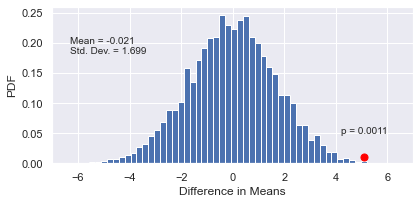

In [360]:
nor_home = dfall[dfall['Home_Team']=='New Orleans Saints']
nor_away = dfall[dfall['Vis_Team']=='New Orleans Saints']
nor_mean_diff = permuted(nor_home['H_Game'],nor_away['V_Game'],diff_of_means)

p = 1.0 - stats.percentileofscore(nor_mean_diff,5.075)/100

mu = np.mean(nor_mean_diff)
sd = np.std(nor_mean_diff)

ymax = 0.26
y1 = ymax
y2 = 0.0
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
_ = plt.hist(nor_mean_diff,bins=55,density=True,label='Seasonal mean Over%',zorder=1)
_ = plt.ylim(0,ymax)
_ = plt.xlim(-7,7)
ax.text(0.05,0.7,'Mean = {0:.3f}\nStd. Dev. = {1:.3f}'.format(mu,sd),transform=ax.transAxes,fontsize='small')
ax.text(4.2,0.05,'p = {:.4f}'.format(p),fontsize='small')
_ = plt.xlabel('Difference in Means')
_ = plt.ylabel('PDF')
_ = plt.scatter(5.075,0.01,marker='.',color='red',s=200,zorder=2)
fig.tight_layout()
fig.show()

mu = 0.027, sd = 2.447, p = 0.015


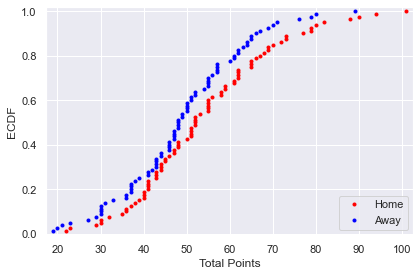

In [387]:
ntot_home = dfall[dfall['Home_Team']=='New Orleans Saints']
ntot_away = dfall[dfall['Vis_Team']=='New Orleans Saints']
ntot_mean_diff = permuted(ntot_home['Tot_Pts'],ntot_away['Tot_Pts'],diff_of_means)

p = 1.0 - stats.percentileofscore(ntot_mean_diff,5.300)/100
fig12 = plt.figure(figsize=(6,4))

mu = np.mean(ntot_mean_diff)
sd = np.std(ntot_mean_diff)

for _ in range(100):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(ntot_home['Tot_Pts'],ntot_away['Tot_Pts'])


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

#     # Plot ECDFs of permutation sample
#     _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
#                  color='red', alpha=0.02)
#     _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
#                  color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(ntot_home['Tot_Pts'])
x_2, y_2 = ecdf(ntot_away['Tot_Pts'])
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red',label='Home')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue',label='Away')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Total Points')
_ = plt.ylabel('ECDF')
_ = plt.legend(loc='lower right')
fig12.tight_layout()
fig12.show()
fig12.savefig('plots/fig12.png')
print('mu = {0:.3f}, sd = {1:.3f}, p = {2:.3f}'.format(mu,sd,p))

In [388]:
dfall['Tot_Pts'].mean()

45.28800312622118

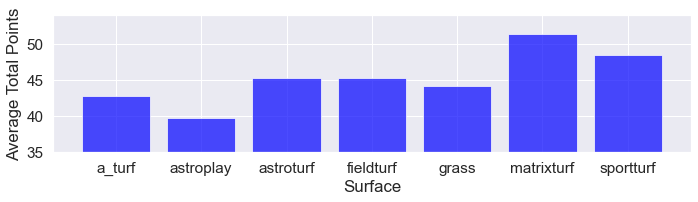

In [847]:
fig10 = plt.figure(figsize=(10,3))
ax = fig10.add_subplot(1,1,1)
ax.set_xlabel('Surface')
ax.set_ylabel('Average Total Points')
ax.set_ylim(35,54)
ax.bar(avg_pts_surf.index,avg_pts_surf.values,color='blue',alpha=0.7)
fig10.show()
fig10.tight_layout()
fig10.savefig('plots/fig10.png')

In [340]:
avg_pts_surf.values

array([42.77419355, 39.8       , 45.22222222, 45.31740614, 44.19709208,
       51.41935484, 48.43209877])

In [761]:
matrix=dfall[dfall['matrixturf']==1]['Tot_Pts']
no_matrix=dfall[dfall['matrixturf']==0]['Tot_Pts']
t_result,p_result=stats.ttest_ind(matrix,no_matrix,equal_var=False)
print(f't = {t_result}, p = {p_result}')

t = 3.20715277387888, p = 0.002148267792649663


In [775]:
cols = X_show.columns[51:57]

In [238]:
domed = X_show[X_show['dome']==1]
notdomed = X_show[X_show['dome']==0]

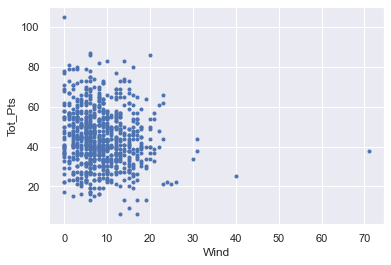

In [239]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
#_ = plt.ylim(0.05,0.15)
_ = plt.plot(notdomed['Wind'],notdomed['Tot_Pts'],marker='.',linestyle='None')
fig.show()
#fig8.savefig('plots/fig8.png')

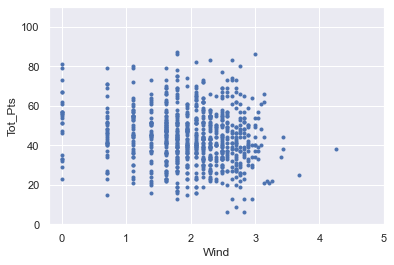

In [270]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
_ = plt.xlim(-0.2,5)
_ = plt.ylim(0,110)
_ = plt.plot(np.log(notdomed['Wind']),notdomed['Tot_Pts'],marker='.',linestyle='None')
fig.show()
#fig8.savefig('plots/fig8.png')

In [ ]:
fig80 = plt.figure(figsize=(7,4))
ind = np.arange(len(grouped['Tot_Pts'].mean()))
counts = grouped['Tot_Pts'].count().values
# alp = counts/max(counts)
# colors = [(0,0.7,0,alp[a]) for a in range(len(alp))]
colors = (0,0.7,0)
_ = plt.bar(ind,grouped['Tot_Pts'].mean().values,color=colors)
_ = plt.xticks(ind,labels=('< 30','30-40','40-50','50-60','60-70','70-80','> 80'))
_ = plt.ylim(40,48)
_ = plt.xlabel('Temperature (°F)')
_ = plt.ylabel('Total Points')
_ = plt.title('Outside Games')
fig97.tight_layout()
plt.show()
fig97.savefig('plots/fig97.png')

In [317]:
val = wadj[wadj['Wind_adj'] > 0]['Wind_adj'].values
val = np.log(val)
wadj.loc[wadj['Wind_adj'] > 0,'Wind_adj'] = val
wadj.loc[wadj['Wind_adj']==0,'Wind_adj'] = wadj.loc[wadj['Wind_adj'] > 0,'Wind_adj'].min()
wadj.drop('Wind',axis=1,inplace=True)

In [252]:
X_show['Tot_Pts'].corr(X_show['Wind'])

-0.12121098510402177

In [265]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(np.log(X_show['Wind']))

-0.13748639619273526

In [343]:
X_show['Tot_Pts'].corr(np.sqrt(X_show['Wind']))

-0.1148841522446934

In [319]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(wadj.Wind_adj)

-0.1291522468997609

In [269]:
X_show[X_show['Wind'] > 0]['Tot_Pts'].corr(1./(X_show['Wind']))

0.13573609073790158

In [320]:
notdomed[notdomed['Wind']>0]['Tot_Pts'].corr(wadj.Wind_adj)

-0.1291522468997609

In [ ]:
sns.pairplot(X_train.iloc[:,0:10])

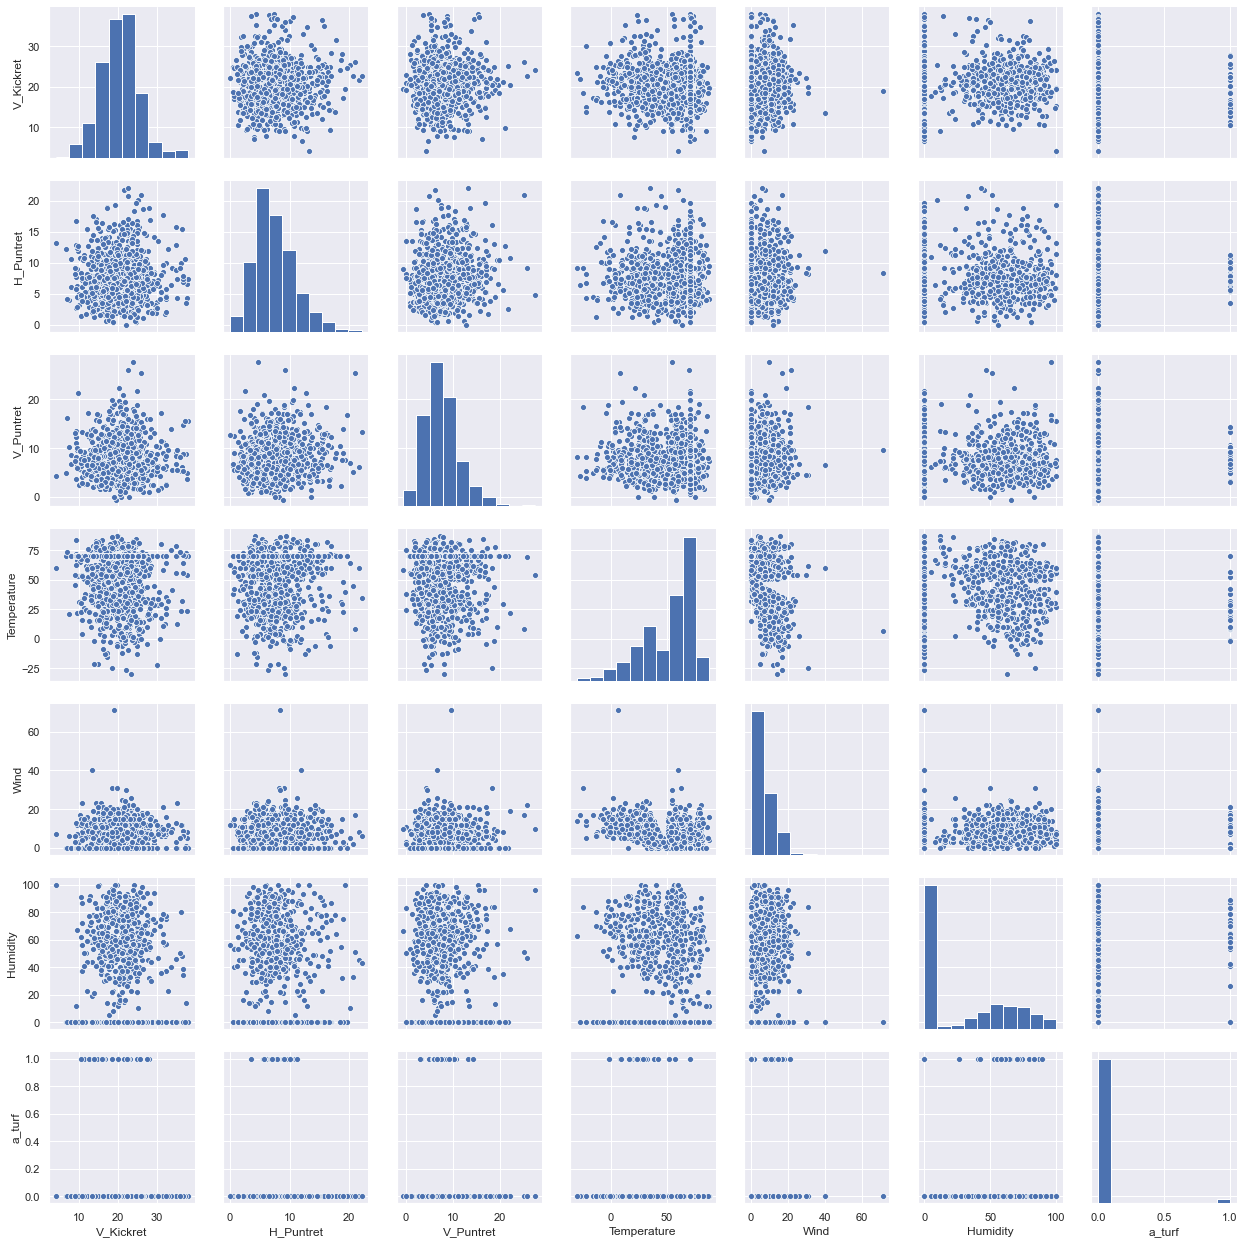

In [367]:
sns.pairplot(X_train.iloc[:,39:46])

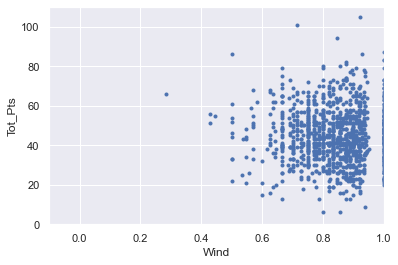

In [365]:
fig = plt.figure()
_ = fig.add_subplot(1,1,1)
_ = plt.xlabel('Wind')
_ = plt.ylabel('Tot_Pts')
_ = plt.xlim(-0.1)
_ = plt.ylim(0,110)
_ = plt.plot((X_show['H_FG_Pct']),X_show['Tot_Pts'],marker='.',linestyle='None')


In [329]:
factor=np.arange(0.0,0.75,0.05)
mae=np.empty(len(factor))
acc=np.empty(len(factor))
for ind,n in enumerate(factor):
    path = 'data/df_working6_{:.2f}.pkl'.format(n)
    with open(path, 'rb') as f:
        df = pickle.load(f)
    df.dropna(inplace=True)

    X = df.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    X = X.drop(turf,axis=1)
    X = X.drop(vifdrop,axis=1)
    y = df['Tot_Pts']
    wtx_train,wtx_test,wty_train,wty_test = train_test_split(X,y,test_size = 1-train_ratio,random_state = 77)
    m, a = regress(LR,wtx_train,wtx_test,wty_train,wty_test,
                   print_metrics=True,print_coef=False,return_metrics=True)
    mae[ind]=m
    acc[ind]=a
print(mae)
print(acc)

MAE_train = 10.576±0.403, Accuracy = 0.536±0.023
MAE_test = 10.689, Accuracy_test = 0.575
MAE_train = 10.604±0.377, Accuracy = 0.542±0.019
MAE_test = 10.745, Accuracy_test = 0.541
MAE_train = 10.605±0.369, Accuracy = 0.532±0.019
MAE_test = 10.747, Accuracy_test = 0.536
MAE_train = 10.607±0.364, Accuracy = 0.529±0.012
MAE_test = 10.750, Accuracy_test = 0.532
MAE_train = 10.610±0.362, Accuracy = 0.527±0.015
MAE_test = 10.750, Accuracy_test = 0.536
MAE_train = 10.614±0.361, Accuracy = 0.526±0.021
MAE_test = 10.747, Accuracy_test = 0.536
MAE_train = 10.620±0.363, Accuracy = 0.524±0.017
MAE_test = 10.742, Accuracy_test = 0.541
MAE_train = 10.629±0.367, Accuracy = 0.522±0.019
MAE_test = 10.734, Accuracy_test = 0.541
MAE_train = 10.639±0.373, Accuracy = 0.522±0.014
MAE_test = 10.727, Accuracy_test = 0.532
MAE_train = 10.648±0.379, Accuracy = 0.522±0.014
MAE_test = 10.721, Accuracy_test = 0.541
MAE_train = 10.657±0.386, Accuracy = 0.522±0.018
MAE_test = 10.713, Accuracy_test = 0.545
MAE_train 

In [330]:
factor=np.arange(0.0,0.75,0.05)
mae=np.empty(len(factor))
acc=np.empty(len(factor))
for ind,n in enumerate(factor):
    path = 'data/df_working4_{:.2f}.pkl'.format(n)
    with open(path, 'rb') as f:
        df = pickle.load(f)
    df.dropna(inplace=True)

    X = df.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    X = X.drop(turf,axis=1)
    X = X.drop(vifdrop,axis=1)
    y = df['Tot_Pts']
    wtx_train,wtx_test,wty_train,wty_test = train_test_split(X,y,test_size = 1-train_ratio,random_state = 77)
    m, a = regress(LR,wtx_train,wtx_test,wty_train,wty_test,
                   print_metrics=True,print_coef=False,return_metrics=True)
    mae[ind]=m
    acc[ind]=a
print(mae)
print(acc)

MAE_train = 10.686±0.171, Accuracy = 0.523±0.017
MAE_test = 10.335, Accuracy_test = 0.527
MAE_train = 10.698±0.193, Accuracy = 0.513±0.014
MAE_test = 10.362, Accuracy_test = 0.519
MAE_train = 10.693±0.194, Accuracy = 0.508±0.013
MAE_test = 10.345, Accuracy_test = 0.519
MAE_train = 10.689±0.193, Accuracy = 0.506±0.019
MAE_test = 10.332, Accuracy_test = 0.534
MAE_train = 10.685±0.193, Accuracy = 0.509±0.019
MAE_test = 10.322, Accuracy_test = 0.527
MAE_train = 10.682±0.192, Accuracy = 0.510±0.017
MAE_test = 10.313, Accuracy_test = 0.523
MAE_train = 10.680±0.192, Accuracy = 0.512±0.014
MAE_test = 10.304, Accuracy_test = 0.523
MAE_train = 10.680±0.191, Accuracy = 0.511±0.013
MAE_test = 10.296, Accuracy_test = 0.530
MAE_train = 10.681±0.191, Accuracy = 0.515±0.012
MAE_test = 10.289, Accuracy_test = 0.537
MAE_train = 10.683±0.192, Accuracy = 0.512±0.015
MAE_test = 10.283, Accuracy_test = 0.541
MAE_train = 10.686±0.192, Accuracy = 0.512±0.015
MAE_test = 10.276, Accuracy_test = 0.541
MAE_train 

In [26]:
X_train

,H_Pts,H_Pts_Opp,V_Pts,V_Pts_Opp,H_Off_Pass,H_Pass_Metric,V_Off_Pass,V_Pass_Metric,H_Off_Rush,H_Rush_Metric,...,H_Kickret,V_Kickret,H_Puntret,V_Puntret,Temperature,Wind,Humidity,grass,Week,dome
Code,,,,,,,,,,,,,,,,,,,,,
201411230nwe,40.500000,21.333333,17.166667,15.666667,313.333333,20.5,255.000000,10.25,127.833333,28.5,...,21.750000,9.916667,19.500000,8.958333,58.00000,7.0,40,0,12,0
201911170ram,24.833333,23.666667,18.666667,19.666667,316.000000,23.5,206.166667,6.00,82.500000,13.0,...,17.500000,17.055556,3.611111,11.033333,79.00000,0.0,20,1,11,0
201511300cle,16.833333,29.166667,22.166667,24.166667,288.333333,17.0,289.833333,18.75,66.166667,13.5,...,20.694444,9.333333,5.138889,2.691667,40.23866,9.0,58,1,12,0
201910200sea,27.500000,24.333333,30.666667,23.333333,284.000000,16.0,260.333333,14.00,130.500000,27.0,...,21.416667,27.194444,2.666667,5.250000,46.76556,8.0,79,0,7,0
201601030car,34.500000,20.500000,23.500000,23.666667,257.166667,16.5,259.666667,18.25,152.333333,26.0,...,13.483333,25.000000,2.694444,7.250000,54.00000,4.0,31,1,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201511220phi,25.666667,20.166667,23.666667,26.166667,295.833333,23.0,246.833333,15.00,143.833333,29.5,...,15.916667,11.236111,10.732143,7.638889,42.08246,15.0,41,1,11,0
201812300oti,20.833333,19.833333,23.333333,14.666667,209.166667,15.0,306.333333,27.00,150.666667,27.5,...,25.291667,10.666667,3.833333,2.750000,53.00000,4.0,0,1,17,0
201112240dal,28.166667,20.166667,23.166667,21.500000,276.166667,18.5,246.000000,15.50,118.500000,19.5,...,14.972222,22.263889,5.597222,3.555556,70.00000,0.0,0,0,16,1


In [346]:
from sklearn.linear_model import Lasso
# path = 'data/df_working6_sh.pkl'.format(n)
# with open(path, 'rb') as f:
#     df = pickle.load(f)
# X = df.drop(turf,axis=1)
path = 'data/df_working6.pkl'.format(n)
with open(path, 'rb') as f:
    df = pickle.load(f)
X = df.drop(turf,axis=1)
X = X.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
y = df['Tot_Pts']
lasso = Lasso(alpha=0.01,normalize=True)
lasso.fit(X,y)
lasso_coef = lasso.fit(X,y).coef_
coef=get_coef(lasso_coef,X.columns)
print(coef)

                LR Coefficient
V_Def_RZ_Pct          5.018737
H_Pts                 0.252393
Wind                 -0.168952
V_Pts                 0.164201
V_Tackles_Loss        0.116457
V_Off_Pass            0.031371
H_Def_Rush            0.021632
H_Off_Pass            0.018961
V_Def_Pass            0.016774
H_Yds_Pen             0.012838
V_Def_Rush            0.010955
H_Def_Pass            0.001317
grass                -0.000000
V_Rush_Metric        -0.000000
H_FG_Pct             -0.000000
V_TD_on_Def          -0.000000
H_TD_on_Def          -0.000000
H_Rush_Metric        -0.000000
V_Off_Rush            0.000000
H_RZ_Pct             -0.000000
H_Off_Rush            0.000000
V_Pass_Metric        -0.000000
H_Pass_Metric        -0.000000
V_Pts_Opp             0.000000
H_Pts_Opp             0.000000
V_FG_Pct              0.000000
H_Def_RZ_Pct         -0.000000
V_RZ_Pct              0.000000
V_Yds_Pen             0.000000
Temperature           0.000000
V_Puntret            -0.000000
H_Puntre

In [366]:
from sklearn.linear_model import Ridge
cols=['V_Def_RZ_Pct','H_Pts','Wind','V_Pts','V_Tackles_Loss','V_Off_Pass','H_Def_Rush','H_Off_Pass',
      'V_Def_Pass','H_Yds_Pen','V_Def_Rush','H_Def_Pass']
path = 'data/df_working6.pkl'.format(n)
with open(path, 'rb') as f:
    df = pickle.load(f)
X = df.drop(turf,axis=1)
X = X[cols]
y = df['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
alphas=np.logspace(-3, 0, 40)
mae = np.empty(40)
acc = np.empty(40)
for ind,alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha,normalize=True)
    m,a=regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=False,return_metrics=True)
    mae[ind] = m
    acc[ind] = a
print(mae)
print(acc)

[10.60693848 10.60682593 10.60669161 10.60653135 10.60634013 10.606112
 10.60583988 10.60551533 10.60512832 10.60466691 10.60411696 10.60346167
 10.60268113 10.60175181 10.60064592 10.59933069 10.59776761 10.59591158
 10.5937099  10.59110132 10.588015   10.58436953 10.58007201 10.57501748
 10.56908855 10.56215572 10.55407848 10.54531581 10.53542851 10.52423046
 10.51362147 10.50294421 10.49284829 10.48131277 10.46908591 10.45627587
 10.4431029  10.43086393 10.41965179 10.4114039 ]
[0.53218884 0.53218884 0.53218884 0.53218884 0.53218884 0.53218884
 0.53218884 0.53218884 0.53218884 0.53218884 0.53218884 0.53218884
 0.53218884 0.53218884 0.53218884 0.53218884 0.53218884 0.53218884
 0.527897   0.53218884 0.53218884 0.53218884 0.53218884 0.53218884
 0.54077253 0.54077253 0.54077253 0.54506438 0.56223176 0.56223176
 0.55364807 0.55793991 0.55793991 0.54506438 0.54935622 0.54077253
 0.53218884 0.53648069 0.53648069 0.54506438]


In [361]:
ridge=Ridge(alpha=0.15,normalize=True)
regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=True,return_metrics=False)

MAE_train = 10.565±0.423, Accuracy = 0.536±0.026
MAE_test = 10.532, Accuracy_test = 0.562


In [374]:
from sklearn.linear_model import Ridge
cols=['H_Pts', 'V_Pts', 'H_Off_Pass', 'V_Off_Pass', 'H_Def_Rush','V_Def_Rush', 'H_RZ_Pct', 'V_RZ_Pct', 
      'H_Sacks_Def', 'Wind', 'grass','dome']
path = 'data/df_working6.pkl'
with open(path, 'rb') as f:
    df = pickle.load(f)
X = df.drop(turf,axis=1)
X = X[cols]
y = df['Tot_Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_ratio, random_state=77)
alphas=np.logspace(-3, 0, 40)
mae = np.empty(40)
acc = np.empty(40)
for ind,alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha,normalize=True)
    m,a=regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=False,return_metrics=True)
    mae[ind] = m
    acc[ind] = a
print(mae)
print(acc)

[10.6883295  10.68818584 10.68801446 10.68781003 10.68756621 10.68727547
 10.68692886 10.68651575 10.68602352 10.68543723 10.68473921 10.68390859
 10.68292077 10.68174685 10.68035291 10.67869937 10.67674014 10.67442184
 10.67168301 10.66845329 10.66465276 10.66019144 10.65496908 10.64887526
 10.64184314 10.63371959 10.62552486 10.61814773 10.60961686 10.60062468
 10.59144631 10.58099951 10.56920606 10.55601315 10.54155396 10.52836589
 10.51437257 10.50459539 10.49534567 10.48772243]
[0.57081545 0.57081545 0.57081545 0.57081545 0.57081545 0.57081545
 0.57081545 0.57081545 0.57081545 0.57081545 0.57081545 0.57081545
 0.57081545 0.57081545 0.57081545 0.57081545 0.57081545 0.56652361
 0.56652361 0.56652361 0.56652361 0.57081545 0.56652361 0.56223176
 0.56223176 0.56652361 0.56652361 0.56652361 0.56652361 0.55793991
 0.56223176 0.56223176 0.55364807 0.54506438 0.54506438 0.54935622
 0.54506438 0.54077253 0.54077253 0.53648069]


In [377]:
ridge=Ridge(alpha=0.08,normalize=True)
regress(ridge,X_train,X_test,y_train,y_test,print_coef=False,print_metrics=True,return_metrics=False)

MAE_train = 10.566±0.417, Accuracy = 0.541±0.024
MAE_test = 10.636, Accuracy_test = 0.567


In [367]:
alphas

array([0.001     , 0.00119378, 0.0014251 , 0.00170125, 0.00203092,
       0.00242446, 0.00289427, 0.00345511, 0.00412463, 0.00492388,
       0.00587802, 0.00701704, 0.00837678, 0.01      , 0.01193777,
       0.01425103, 0.01701254, 0.02030918, 0.02424462, 0.02894266,
       0.03455107, 0.04124626, 0.04923883, 0.05878016, 0.07017038,
       0.08376776, 0.1       , 0.11937766, 0.14251027, 0.17012543,
       0.20309176, 0.2424462 , 0.28942661, 0.34551073, 0.41246264,
       0.49238826, 0.58780161, 0.70170383, 0.83767764, 1.        ])

In [375]:
X_train

,H_Pts,V_Pts,H_Off_Pass,V_Off_Pass,H_Def_Rush,V_Def_Rush,H_RZ_Pct,V_RZ_Pct,H_Sacks_Def,Wind,grass,dome
Code,,,,,,,,,,,,
201411230nwe,40.500000,17.166667,313.333333,255.000000,96.666667,60.833333,0.615385,0.400000,2.333333,7.0,0,0
201911170ram,24.833333,18.666667,316.000000,206.166667,89.666667,106.666667,0.529412,0.611111,3.000000,0.0,1,0
201511300cle,16.833333,22.166667,288.333333,289.833333,137.000000,91.833333,0.416667,0.538462,1.166667,9.0,1,0
201910200sea,27.500000,30.666667,284.000000,260.333333,92.833333,80.666667,0.653846,0.640000,1.666667,8.0,0,0
201601030car,34.500000,23.500000,257.166667,259.666667,67.833333,97.666667,0.628571,0.600000,2.666667,4.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
201511220phi,25.666667,23.666667,295.833333,246.833333,123.500000,82.500000,0.433333,0.413793,3.000000,15.0,1,0
201812300oti,20.833333,23.333333,209.166667,306.333333,134.500000,94.500000,0.476190,0.640000,2.500000,4.0,1,0
201112240dal,28.166667,23.166667,276.166667,246.000000,92.500000,99.666667,0.531250,0.481481,2.666667,0.0,0,1
